# EFFECT OF THE CONCENTRATION OF PHOTOCHROME MOLECULES ON THE HTPB MATRIX

In [1]:
# Reload all modules
# This is useful when you need to edit a module without
# closing the notebook.

%load_ext autoreload
%autoreload 2

In [2]:
# Load common modules
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import linregress

In [3]:
# Modules STAMPTOOLS

from stamptools.stamp import STAMP
from stamptools.analysis import load_data, read_fatomes
from stamptools.nbconfig import save_fig, rot, rot2, MplotParam, toTime
from stamptools.stamptools import read_geometry_file
from scipy.constants import N_A

In [4]:
# Load my parameters in the matplotlib setting
plt.rcParams.update(MplotParam)

### Parameter definitions

In [5]:
# Definitions

home_path = "~/exp.azob.varN"

n_pc = ["2", "5", "10", "20", "20_agg", "50"]

labels = {
    "trans":"$trans$",
    "cis":r"$cis$",
    "s1":"S$_1$",
    "d_cnnc": "CNNC"
}


Param_colors = {
    "pol": "gray"
}

In [6]:
Param_cnnc = {
    "trans":{
        "step": 1.0,
        "center": 180.0,
        "edge": 20.0,
        "deg": 0.0
    },
    "cis":{
        "step": 1.0,
        "center": 0.0,
        "edge": 20.0,
        "deg": -90.0
    },
    "s1":{
        "step": 1.0,
        "center": 0.0,
        "edge": 180.0,
        "deg": -180.0
    }
}

Param_ccnn = {
    "trans":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -90.0
    },
    "cis":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 0.0,
        "edge": 210.0,
        "deg": -180.0
    },
    "s1":{
        "torsion": ["d_ccnn_1", "d_ccnn_4"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -100.0
    }
}

In [7]:
POLPROP = {
    "Rg": {
        "color": "#2a90a6",
        "binwidth": .1,
        "xlim": [0.5, 3.],  # size 0.5  size vs distance 0.8
        "label": "Radius of gyration (nm)",
        "units": "nm",
        "bins": (0.5, 3.08, 0.08)  # 0.5
    },
    "dmax": {
        "color": "#5b557b",
        "binwidth": .3,
        "xlim": [1.2, 8.0],
        "label": "Max. distance (nm)",
        "units": "nm",
        "bins": (1.0, 9.1, 0.1)
    },
    "k2": {
        "color": "#fea6ad",
        "binwidth": .05,
        "xlim": [0, 1],
        "label": "Shape anisotropy",
        "units": "",
        "bins": (0., 1.02, 0.02)
    },
    "rdf": {
        "color": "#3293f0",
        "xlim": [0.25, 2.5],
        "label": "g(r) PC - POL",
        "ylim": [0, 300],
        "units": ""
        
    },
    "rdf_CM": {
        "color": "#00cc99",
        "xlim": [0.25, 2.5],
        "label": r"g(r) PC$_{CM}$ - PB$_{CM}$",
        "units": "",
        "ylim": [0, 10]
        
    },
    "distance": {
        "color": "#66c0c0",
        "binwidth": 0.01,
        "xlim": [0, 4.0],
        "label": "distance",
        "units": "nm"
    }
}

colorsIsomer = {
    "trans": "#41c325",
    "cis": "#f4c90f",
    "s1": "#e584ac",
    "pb" : "#90634a"
}

In [8]:
def load_NGeom(N, isomer, system, freq=0.1, t0=0.0):
    Geoms = {}
    for i in range(N):
        data = read_geometry_file(
            f"../exp.azob.varN/{isomer}/{N}/{system}/Geometry_mol_{i}.csv",
            freq=freq,
            t0=t0
        )
        
        if isomer == "trans":
            data["d_cnnc"] = data["d_cnnc"].apply(rot2)
            data["d_ccnn_1"] = data["d_ccnn_1"].apply(rot2, phase=90.)
            data["d_ccnn_2"] = data["d_ccnn_2"].apply(rot2, phase=90.)
            data["d_ccnn_3"] = data["d_ccnn_3"].apply(rot2, phase=90.)
            data["d_ccnn_4"] = data["d_ccnn_4"].apply(rot2, phase=90.)
        
        Geoms[str(i)] = data.copy()
    return Geoms
    

## Isomer trans

In [34]:
# Data storage

GEOM = {}
HBONDS_list = []
RDFs = {}
SIZES = {}

### N=2

In [35]:
N = 2 # <-----
isomer = "trans" # <----
system = "5_prod"

trans_N = load_NGeom(N, isomer, system)
GEOM[N] = trans_N.copy()

#### Dihedral CNNC

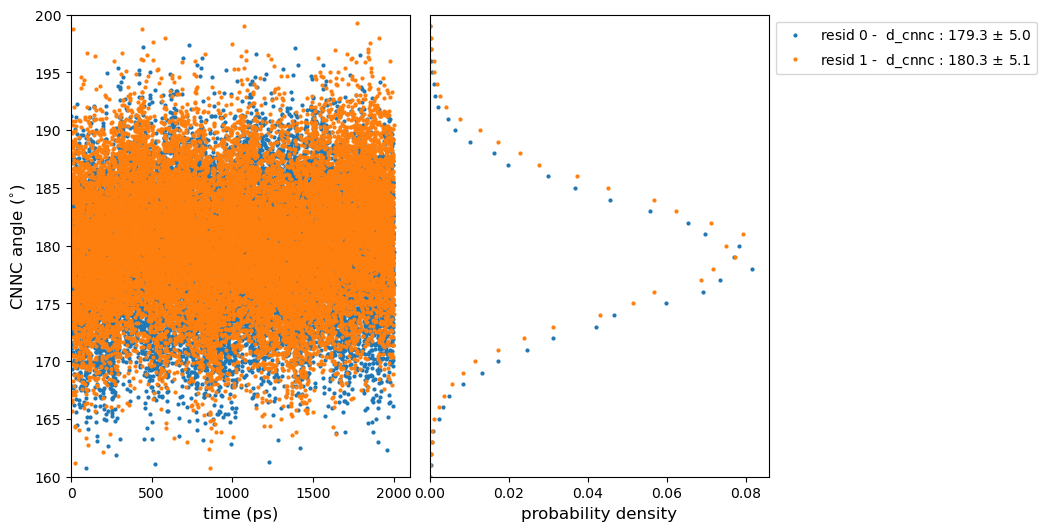

In [36]:
# CNNC

tor = "d_cnnc"
GEOM_NPC = trans_N.copy()
isomer = "trans"


fig, ax = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.06)
for i in GEOM_NPC:
    data = GEOM_NPC[i].copy()
    
    ax[0].plot(
        data["time"],
        data[tor],
        ".",
        ms=4.,
        label=f"resid {i} -  {tor} : {data[tor].mean():.1f} $\pm$ {data[tor].std():.1f}"
    )
    
    bins = np.arange(
            Param_cnnc[isomer]["center"] - Param_cnnc[isomer]["edge"],
            Param_cnnc[isomer]["center"] + Param_cnnc[isomer]["edge"] + Param_cnnc[isomer]["step"],
            Param_cnnc[isomer]["step"]
        )
    
    hist, _ = np.histogram(data[tor], bins=bins, density=True)
    ax[1].plot(
        hist,
        bins[:-1],
        ".",
        ms = 4.,
        label=f"resid {i} -  {tor} : {data[tor].mean():.1f} $\pm$ {data[tor].std():.1f}"
    )


ax[0].set_xlabel("time (ps)")
ax[0].set_ylabel("CNNC angle ($^{\circ}$)")
ax[0].set_ylim(160, 200)
ax[0].set_xlim(xmin=0.0)
    
ax[1].set_xlabel("probability density")
ax[1].get_yaxis().set_visible(False)
ax[1].set_ylim(160, 200)
ax[1].set_xlim(xmin=0.0)

ax[1].legend(bbox_to_anchor=(1., 1.), fontsize=10, loc="upper left")

save_fig("{}_{}pc_pboh_cnnc.png".format(isomer, len(GEOM_NPC)), "../figures/")
plt.show()

#### Dihedrals CCNN

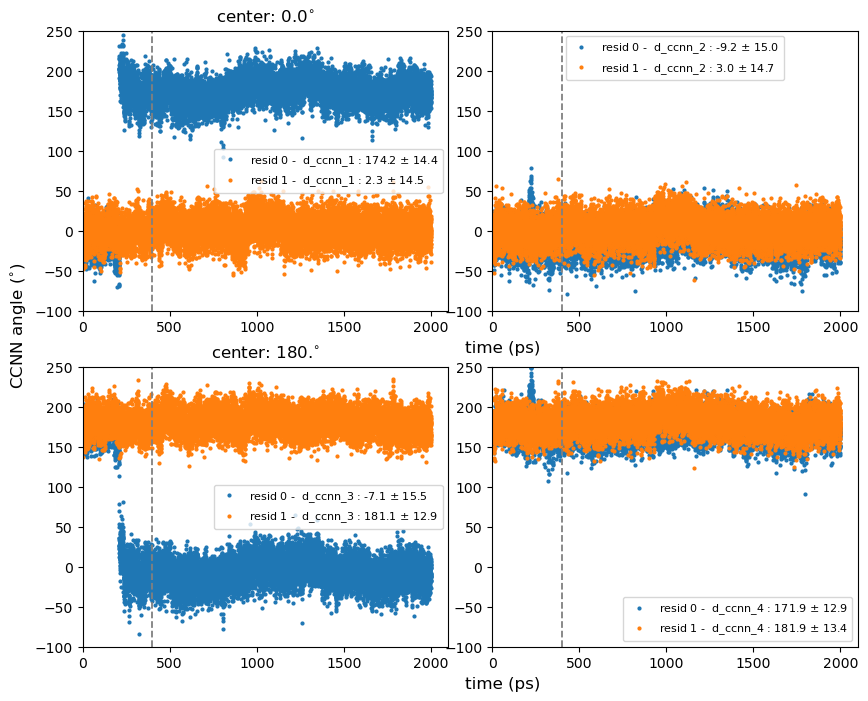

In [37]:
# CNNC

GEOM_NPC = trans_N.copy()
isomer = "trans"

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.12)


titles = [
    "center: 0.0$^{\circ}$",
    "center: 180.$^{\circ}$"
]

dihedrals = [
    ["d_ccnn_1", "d_ccnn_2"],
    ["d_ccnn_3", "d_ccnn_4"]
]

for i, title in enumerate(titles):
    ax[i, 0].set_title(title)
    row_dih = dihedrals[i]
    for j, tor in enumerate(row_dih):
        for n in GEOM_NPC:
            data = GEOM_NPC[n].copy()
            ax[i, j].plot(
                data["time"], data[tor],
                ".",
                ms = 4.,
                label="resid {} -  {} : {:.1f} $\pm$ {:.1f}".format(n, tor, data[data["time"] > 400.][tor].mean(), data[data["time"] > 400.][tor].std())
            )
        ax[i, j].legend(fontsize=8.)
        ax[i, j].set_xlim(xmin=0.0)
        ax[i, j].set_ylim(-100., 250)
        ax[i, j].axvline(x=400., ls="--", lw=1.3, color="gray")
        
    ax[i, 0].set_xlabel("time (ps)", x=1.15)
    
ax[1, 0].set_ylabel("CCNN angle ($^{\circ}$)", y=1.15)

# ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.3, 0.8))

# save_fig("trans_5pc_pboh_ccnn.png", "../figures/")

save_fig("{}_{}pc_pboh_ccnn.png".format(isomer, len(GEOM_NPC)), "../figures/")
plt.show()

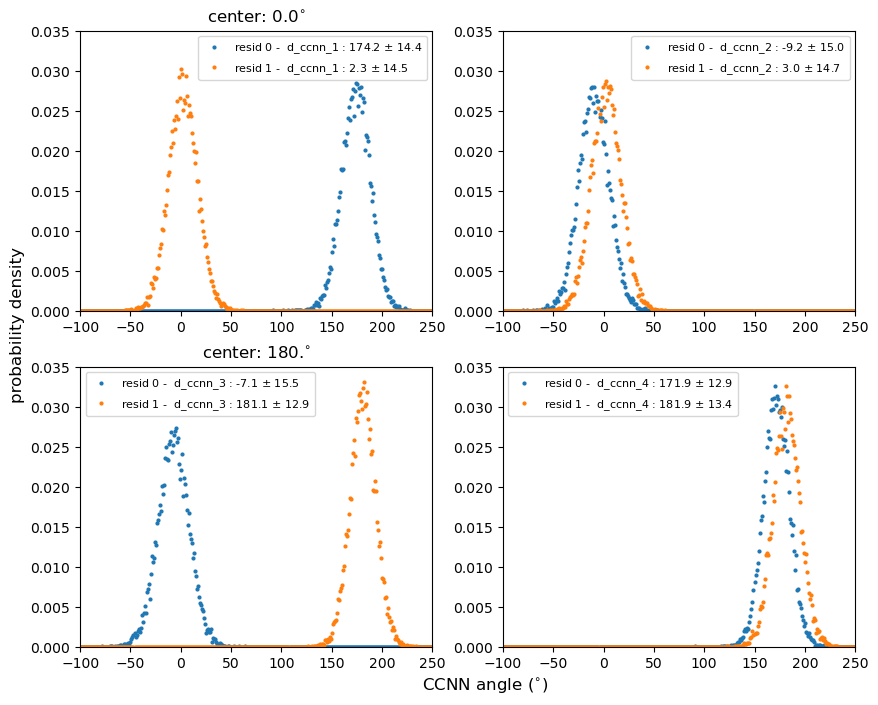

In [38]:
# CNNC

GEOM_NPC = trans_N.copy()
isomer = "trans"

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.2)

bins = np.arange(
            Param_ccnn[isomer]["center"] - Param_ccnn[isomer]["edge"],
            Param_ccnn[isomer]["center"] + Param_ccnn[isomer]["edge"] + Param_ccnn[isomer]["step"],
            Param_ccnn[isomer]["step"]
        )


titles = [
    "center: 0.0$^{\circ}$",
    "center: 180.$^{\circ}$"
]

dihedrals = [
    ["d_ccnn_1", "d_ccnn_2"],
    ["d_ccnn_3", "d_ccnn_4"]
]

for i, title in enumerate(titles):
    ax[i, 0].set_title(title)
    row_dih = dihedrals[i]
    for j, tor in enumerate(row_dih):
        for n in GEOM_NPC:
            data = GEOM_NPC[n].copy()
            hist, _ = np.histogram(data[data["time"] > 400.][tor], bins=bins, density=True)
            ax[i, j].plot(
                bins[:-1],
                hist,
                ".",
                ms = 4.,
                label="resid {} -  {} : {:.1f} $\pm$ {:.1f}".format(n, tor, data[data["time"] > 400.][tor].mean(), data[data["time"] > 400.][tor].std())
            )
        ax[i, j].legend(fontsize=8.)
        ax[i, j].set_ylim(0, 0.035)
        ax[i, j].set_xlim(-100., 250)


ax[1, 0].set_ylabel("probability density", y=1.15)
ax[1, 0].set_xlabel("CCNN angle ($^{\circ}$)", x=1.15)

# ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.3, 0.8))

save_fig("{}_{}pc_pboh_ccnn_hist.png".format(isomer, len(GEOM_NPC)), "../figures/")

plt.show()

#### Hydrogen bonds

In [39]:
isomer = "trans"
N = 2

hbonds = pd.read_csv(
    f"../exp.azob.varN/{isomer}/{N}/5_prod/hbonds_all.dat",
    header=None, sep="\s+",
    names=["frame", "n_hb"]
)

hbonds["time"] = (hbonds["frame"] - 1) * .1
hbonds = hbonds[hbonds["n_hb"] !=0]
hbonds["N"] = N
HBONDS_list.append(hbonds)

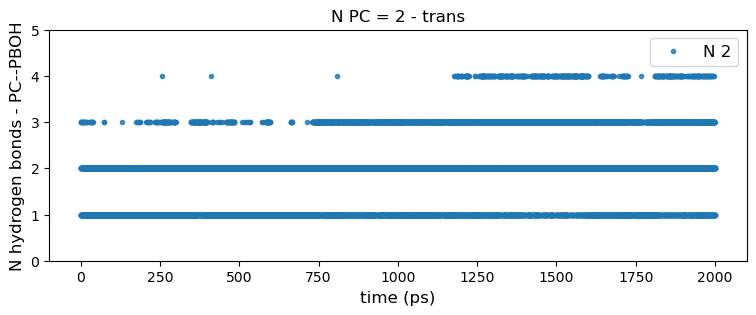

In [40]:
# CNNC

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title(f"N PC = {N} - {isomer}")
marks = ['o', 'x', '<', 's', 'D']
ax.plot(
    hbonds["time"], hbonds["n_hb"], ".",
    label="N {}".format(N),
    alpha=0.8
)

ax.set_xlabel("time (ps)")
ax.set_ylabel("N hydrogen bonds - PC--PBOH")
ax.set_yticks(range(0, 2*N+2))
# ax.set_ylim(0, 2*N+2)

ax.legend()

save_fig(f"{isomer}_{N}pc_pboh_hbonds.png", "../figures/")
plt.show()

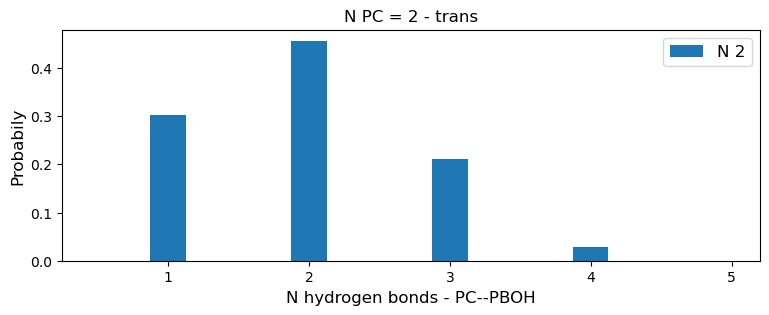

In [41]:
# CNNC

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title(f"N PC = {N} - {isomer}")
multiplier = 0
width = 0.25  # the width of the bars
# width = 1 / (len(hbonds) + 1)  # the width of the bars

data = hbonds.copy()
bins = np.arange(0, 2 * N + 2, 1)
hist, _ = np.histogram(data["n_hb"], bins=bins, density=True)    
offset = width * multiplier
rects = ax.bar(
    bins[:-1] + offset,
    hist,
    width=width,
    label="N {}".format(N)
)
# ax.bar_label(rects, padding=3)
# multiplier += 1


ax.set_ylabel("Probabily")
ax.set_xlabel("N hydrogen bonds - PC--PBOH")
ax.set_xlim(0.25, 2*N + 1+ 0.2)
# ax.set_xticks(range(0, 2*N +1 + 0.5))

ax.legend()

save_fig(f"{isomer}_{N}pc_pboh_hbonds_bars.png", "../figures/")
plt.show()

#### Sizes and shape

In [42]:
isomer = "trans"
N=2

path_mol = "../exp.azob.varN/{}/{}/5_prod/molprop.csv".format(isomer, N)
sizes = pd.read_csv(f"{path_mol}")
sizes["time"] = sizes["frame"].apply(toTime, freq=0.1, t0=0.1)
sizes["Rg"] *= 0.1
sizes["dmax"] *= 0.1
sizes = sizes[sizes["idx"] > N]

SIZES[N] = sizes.copy()

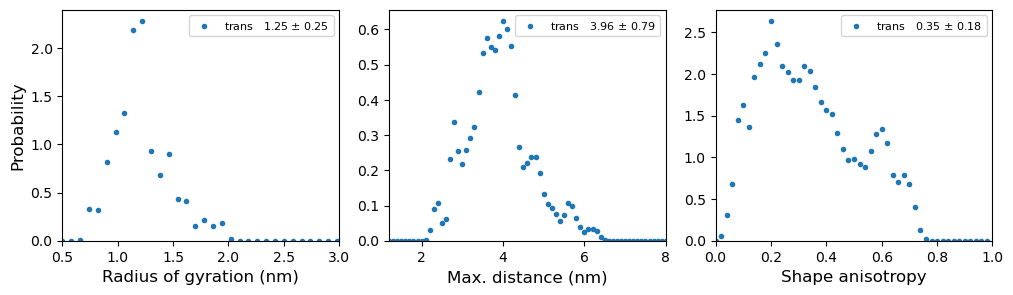

In [43]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))
fig.subplots_adjust(wspace=0.18)

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # ax[i].set_title(prop)
    formatProp = POLPROP[prop]
    
    values = sizes[prop].values
    bins = np.arange(*formatProp["bins"])
    hist, _ = np.histogram(values, bins=bins, density=True)
    ax[i].plot(
            bins[:-1],
            hist, ".", ms = 6,
            label = "{}   {:.2f} $\pm$ {:.2f}".format(isomer, values.mean(), values.std()) # label = labels[isomer],
        )
    
    ax[i].set_xlabel(formatProp["label"])
    ax[i].set_xlim(formatProp["xlim"])
    ax[i].set_ylim(ymin=0.0)
    
    ax[i].legend(fontsize=8)
ax[0].set_ylabel("Probability")

# save_fig("{}_{}pc_pboh_sizes.png".format(isomer, N), "../figures/")
plt.show()

#### RDF all atoms

In [44]:
isomer = "trans"
N=2
path_mol = "../exp.azob.varN/{}/{}/5_prod/rdf_all_at_pc_env.csv".format(isomer, N)
rdf = pd.read_csv(path_mol)
RDFs[N] = rdf.copy()

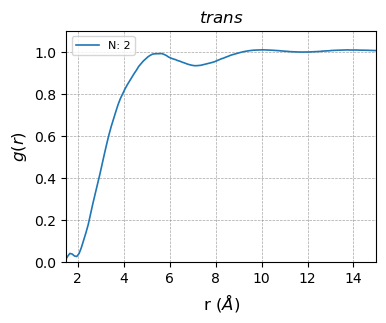

In [45]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3))

ax.set_title(labels[isomer])
ax.plot(rdf["r"], rdf["g_r"], label=f"N: {N}", ls="-", lw=1.2)

ax.set_xlim(1.5, 15.)
ax.set_ylim(0.0, 1.1)
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"$g(r)$")

ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.legend(fontsize=8)

save_fig("{}_{}pc_pboh_rdfallatoms.png".format(isomer, N), "../figures/")

plt.show()

### N=5

In [46]:
N = 5
isomer = "trans"
system = "5_prod"

trans_N = load_NGeom(N, isomer, system)
GEOM[N] = trans_N.copy()

#### Dihedral CNNC

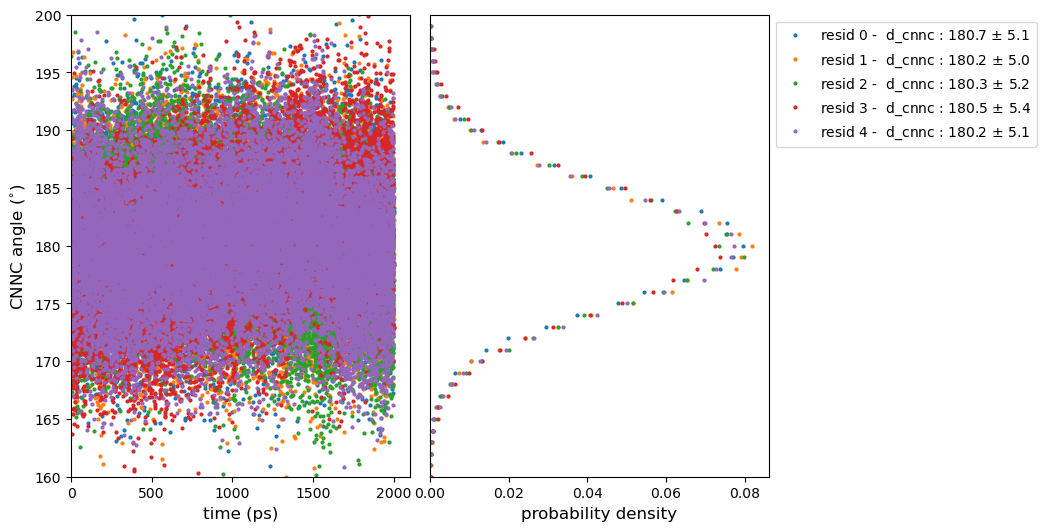

In [47]:
# CNNC

tor = "d_cnnc"
GEOM_NPC = trans_N.copy()
isomer = "trans"


fig, ax = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.06)
for i in GEOM_NPC:
    data = GEOM_NPC[i].copy()
    
    ax[0].plot(
        data["time"],
        data[tor],
        ".",
        ms=4.,
        label=f"resid {i} -  {tor} : {data[tor].mean():.1f} $\pm$ {data[tor].std():.1f}"
    )
    
    bins = np.arange(
            Param_cnnc[isomer]["center"] - Param_cnnc[isomer]["edge"],
            Param_cnnc[isomer]["center"] + Param_cnnc[isomer]["edge"] + Param_cnnc[isomer]["step"],
            Param_cnnc[isomer]["step"]
        )
    
    hist, _ = np.histogram(data[tor], bins=bins, density=True)
    ax[1].plot(
        hist,
        bins[:-1],
        ".",
        ms = 4.,
        label=f"resid {i} -  {tor} : {data[tor].mean():.1f} $\pm$ {data[tor].std():.1f}"
    )


ax[0].set_xlabel("time (ps)")
ax[0].set_ylabel("CNNC angle ($^{\circ}$)")
ax[0].set_ylim(160, 200)
ax[0].set_xlim(xmin=0.0)
    
ax[1].set_xlabel("probability density")
ax[1].get_yaxis().set_visible(False)
ax[1].set_ylim(160, 200)
ax[1].set_xlim(xmin=0.0)

ax[1].legend(bbox_to_anchor=(1., 1.), fontsize=10, loc="upper left")

save_fig("{}_{}pc_pboh_cnnc.png".format(isomer, len(GEOM_NPC)), "../figures/")
plt.show()

#### Dihedrals CCNN

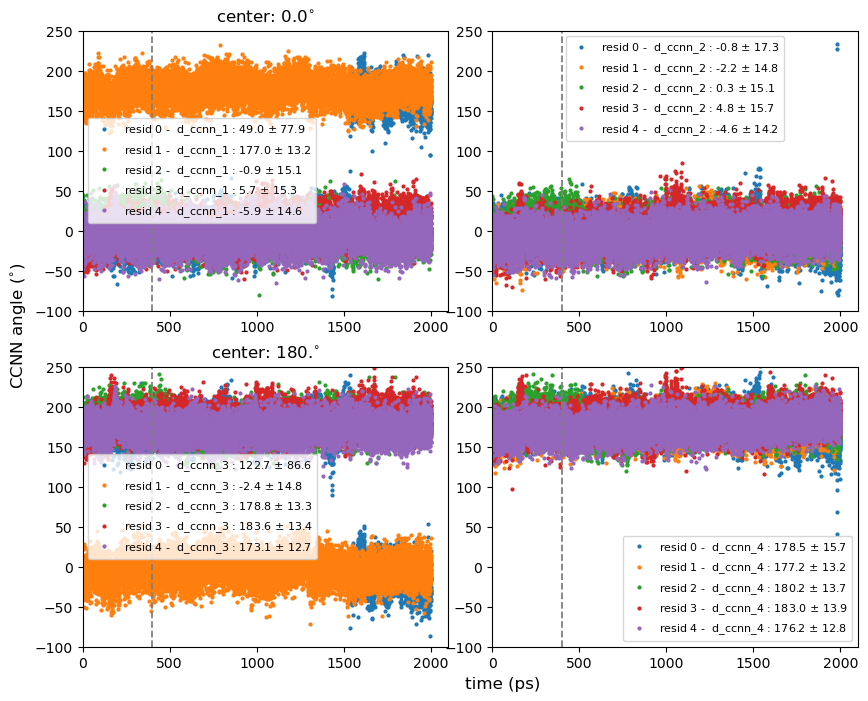

In [48]:
# CNNC

GEOM_NPC = trans_N.copy()
isomer = "trans"

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.12)


titles = [
    "center: 0.0$^{\circ}$",
    "center: 180.$^{\circ}$"
]

dihedrals = [
    ["d_ccnn_1", "d_ccnn_2"],
    ["d_ccnn_3", "d_ccnn_4"]
]

for i, title in enumerate(titles):
    ax[i, 0].set_title(title)
    row_dih = dihedrals[i]
    for j, tor in enumerate(row_dih):
        for n in GEOM_NPC:
            data = GEOM_NPC[n].copy()
            ax[i, j].plot(
                data["time"], data[tor],
                ".",
                ms = 4.,
                label="resid {} -  {} : {:.1f} $\pm$ {:.1f}".format(n, tor, data[data["time"] > 400.][tor].mean(), data[data["time"] > 400.][tor].std())
            )
        ax[i, j].legend(fontsize=8.)
        ax[i, j].set_xlim(xmin=0.0)
        ax[i, j].set_ylim(-100., 250)
        ax[i, j].axvline(x=400., ls="--", lw=1.3, color="gray")
        
    
ax[1, 0].set_xlabel("time (ps)", x=1.15)
ax[1, 0].set_ylabel("CCNN angle ($^{\circ}$)", y=1.15)

# ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.3, 0.8))

# save_fig("trans_5pc_pboh_ccnn.png", "../figures/")

save_fig("{}_{}pc_pboh_ccnn.png".format(isomer, len(GEOM_NPC)), "../figures/")
plt.show()

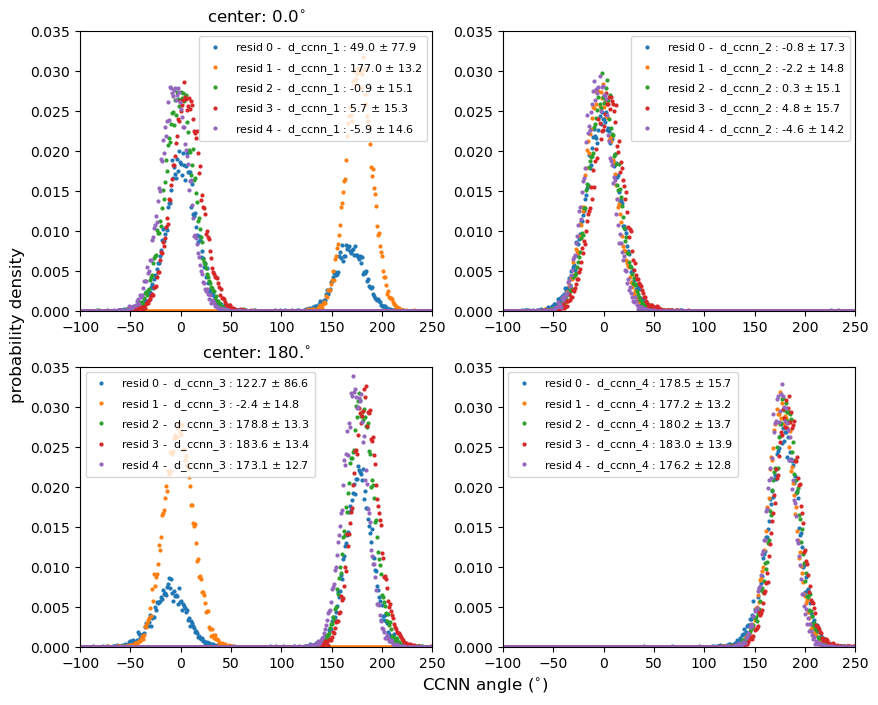

In [49]:
# CNNC

GEOM_NPC = trans_N.copy()
isomer = "trans"

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.2)

bins = np.arange(
            Param_ccnn[isomer]["center"] - Param_ccnn[isomer]["edge"],
            Param_ccnn[isomer]["center"] + Param_ccnn[isomer]["edge"] + Param_ccnn[isomer]["step"],
            Param_ccnn[isomer]["step"]
        )


titles = [
    "center: 0.0$^{\circ}$",
    "center: 180.$^{\circ}$"
]

dihedrals = [
    ["d_ccnn_1", "d_ccnn_2"],
    ["d_ccnn_3", "d_ccnn_4"]
]

for i, title in enumerate(titles):
    ax[i, 0].set_title(title)
    row_dih = dihedrals[i]
    for j, tor in enumerate(row_dih):
        for n in GEOM_NPC:
            data = GEOM_NPC[n].copy()
            hist, _ = np.histogram(data[data["time"] > 400.][tor], bins=bins, density=True)
            ax[i, j].plot(
                bins[:-1],
                hist,
                ".",
                ms = 4.,
                label="resid {} -  {} : {:.1f} $\pm$ {:.1f}".format(n, tor, data[data["time"] > 400.][tor].mean(), data[data["time"] > 400.][tor].std())
            )
        ax[i, j].legend(fontsize=8.)
        ax[i, j].set_ylim(0, 0.035)
        ax[i, j].set_xlim(-100., 250)


ax[1, 0].set_ylabel("probability density", y=1.15)
ax[1, 0].set_xlabel("CCNN angle ($^{\circ}$)", x=1.15)

# ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.3, 0.8))

save_fig("{}_{}pc_pboh_ccnn_hist.png".format(isomer, len(GEOM_NPC)), "../figures/")

plt.show()

#### Hydrogen bonds

In [50]:
isomer = "trans"
N = 5

hbonds = pd.read_csv(
    f"../exp.azob.varN/{isomer}/{N}/5_prod/hbonds_all.dat",
    header=None, sep="\s+",
    names=["frame", "n_hb"]
)

hbonds["time"] = (hbonds["frame"] - 1) * .1
hbonds = hbonds[hbonds["n_hb"] !=0]
hbonds["N"] = N
HBONDS_list.append(hbonds)

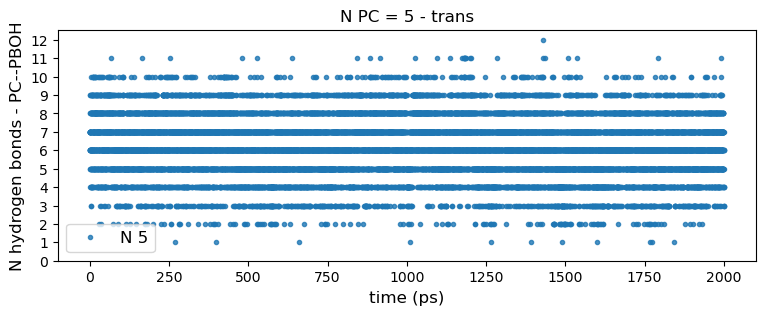

In [51]:
# CNNC

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title(f"N PC = {N} - {isomer}")
marks = ['o', 'x', '<', 's', 'D']
ax.plot(
    hbonds["time"], hbonds["n_hb"], ".",
    label="N {}".format(N),
    alpha=0.8
)

ax.set_xlabel("time (ps)")
ax.set_ylabel("N hydrogen bonds - PC--PBOH")
ax.set_yticks(range(0, 2*N+3))
# ax.set_ylim(0)

ax.legend()

save_fig(f"{isomer}_{N}pc_pboh_hbonds.png", "../figures/")
plt.show()

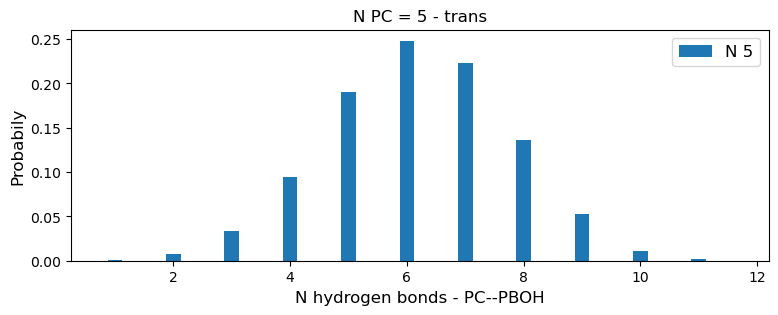

In [52]:
# CNNC

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title(f"N PC = {N} - {isomer}")
multiplier = 0
width = 0.25  # the width of the bars
# width = 1 / (len(hbonds) + 1)  # the width of the bars

data = hbonds.copy()
bins = np.arange(0, 2 * N + 3, 1)
hist, _ = np.histogram(data["n_hb"], bins=bins, density=True)    
offset = width * multiplier
rects = ax.bar(
    bins[:-1] + offset,
    hist,
    width=width,
    label="N {}".format(N)
)
# ax.bar_label(rects, padding=3)
# multiplier += 1


ax.set_ylabel("Probabily")
ax.set_xlabel("N hydrogen bonds - PC--PBOH")
ax.set_xlim(0.25, 2*N + 2+ 0.2)
# ax.set_xticks(range(0, 2*N +1 + 0.5))

ax.legend()

save_fig(f"{isomer}_{N}pc_pboh_hbonds_bars.png", "../figures/")
plt.show()

In [53]:
HBONDS = pd.concat(HBONDS_list, ignore_index=True)

Text(0, 0.5, 'N hydrogen bonds - PC--PBOH')

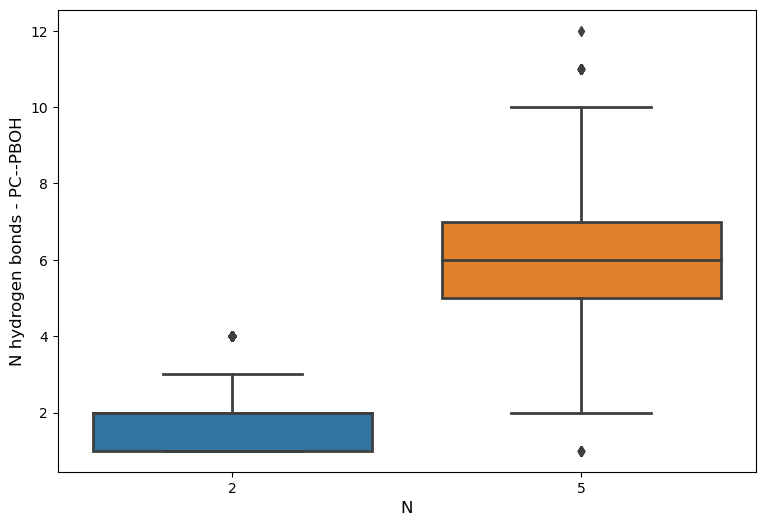

In [54]:
fig, ax = plt.subplots()
sns.boxplot(data=HBONDS, x="N", y="n_hb", ax=ax)

ax.set_ylabel("N hydrogen bonds - PC--PBOH")
# ax.legend(["N 2", "N 5"])

#### Sizes and shape

In [55]:
isomer = "trans"
N=5
path_mol = "../exp.azob.varN/{}/{}/5_prod/molprop.csv".format(isomer, N)
sizes = pd.read_csv(f"{path_mol}")
sizes["time"] = sizes["frame"].apply(toTime, freq=0.1, t0=0.1)
sizes["Rg"] *= 0.1
sizes["dmax"] *= 0.1
sizes = sizes[sizes["idx"] > N]

SIZES[N] = sizes.copy()

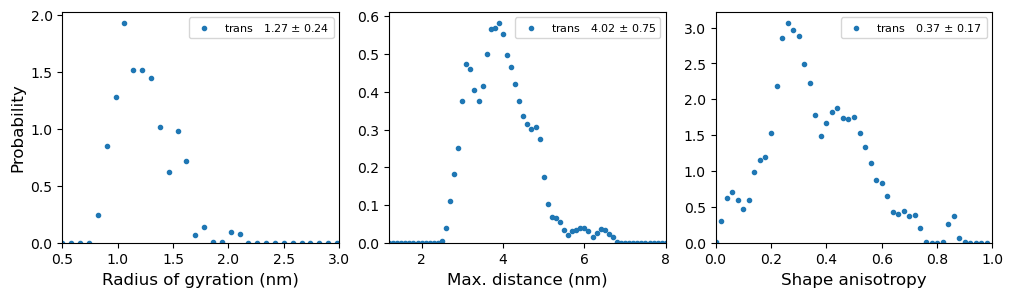

In [56]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))
fig.subplots_adjust(wspace=0.18)

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # ax[i].set_title(prop)
    formatProp = POLPROP[prop]
    
    values = sizes[prop].values
    bins = np.arange(*formatProp["bins"])
    hist, _ = np.histogram(values, bins=bins, density=True)
    ax[i].plot(
            bins[:-1],
            hist, ".", ms = 6,
            label = "{}   {:.2f} $\pm$ {:.2f}".format(isomer, values.mean(), values.std()) # label = labels[isomer],
        )
    
    ax[i].set_xlabel(formatProp["label"])
    ax[i].set_xlim(formatProp["xlim"])
    ax[i].set_ylim(ymin=0.0)
    
    ax[i].legend(fontsize=8)
ax[0].set_ylabel("Probability")

# save_fig("{}_{}pc_pboh_sizes.png".format(isomer, N), "../figures/")
plt.show()

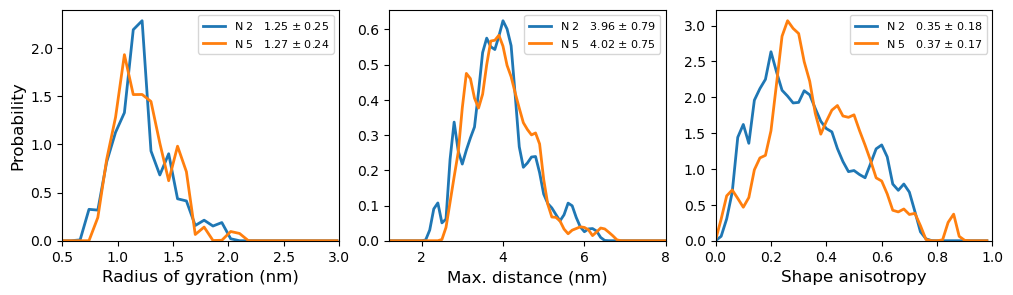

In [57]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))
fig.subplots_adjust(wspace=0.18)

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # ax[i].set_title(prop)
    formatProp = POLPROP[prop]
    
    for n in SIZES:
        sizes = SIZES[n].copy()
        values = sizes[prop].values
        bins = np.arange(*formatProp["bins"])
        hist, _ = np.histogram(values, bins=bins, density=True)
        ax[i].plot(
            bins[:-1],
            hist, "-", ms = 6,
            label = "N {}   {:.2f} $\pm$ {:.2f}".format(n, values.mean(), values.std()) # label = labels[isomer],
        )
    
    ax[i].set_xlabel(formatProp["label"])
    ax[i].set_xlim(formatProp["xlim"])
    ax[i].set_ylim(ymin=0.0)
    
    ax[i].legend(fontsize=8)
ax[0].set_ylabel("Probability")

# save_fig("{}_{}pc_pboh_sizes.png".format(isomer, N), "../figures/")
plt.show()

#### RDF all atoms

In [58]:
isomer = "trans"
N=5
path_mol = "../exp.azob.varN/{}/{}/5_prod/rdf_all_at_pc_env.csv".format(isomer, N)
rdf = pd.read_csv(path_mol)
RDFs[N] = rdf.copy()

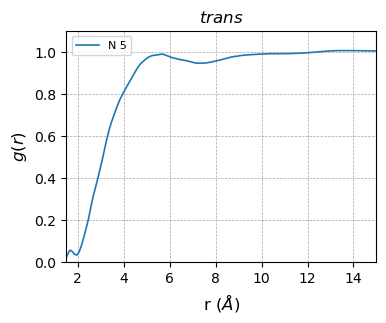

In [59]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3))

ax.set_title(labels[isomer])
ax.plot(rdf["r"], rdf["g_r"], label=f"N {N}", ls="-", lw=1.2)

ax.set_xlim(1.5, 15.)
ax.set_ylim(0.0, 1.1)
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"$g(r)$")

ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.legend(fontsize=8)

save_fig("{}_{}pc_pboh_rdfallatoms.png".format(isomer, N), "../figures/")

plt.show()

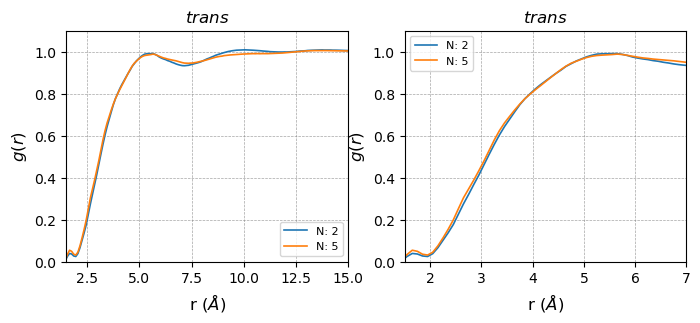

In [60]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,3))

for i, xlim in enumerate([[1.5, 15.], [1.5, 7.]]):
    ax[i].set_title(labels[isomer])
    for n in RDFs:
        rdf = RDFs[n].copy()
        ax[i].plot(rdf["r"], rdf["g_r"], label=f"N: {n}", ls="-", lw=1.2)

    ax[i].set_xlim(xlim)
    ax[i].set_ylim(0.0, 1.1)
    ax[i].set_xlabel(r"r ($\AA$)")
    ax[i].set_ylabel(r"$g(r)$")

    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax[i].legend(fontsize=8)

# save_fig("{}_{}pc_pboh_rdfallatoms.png".format(isomer, N), "../figures/")

plt.show()

### N=10

In [61]:
N = 10
isomer = "trans"
system = "5_prod"

trans_N = load_NGeom(N, isomer, system)
GEOM[N] = trans_N.copy()

#### Dihedral CNNC

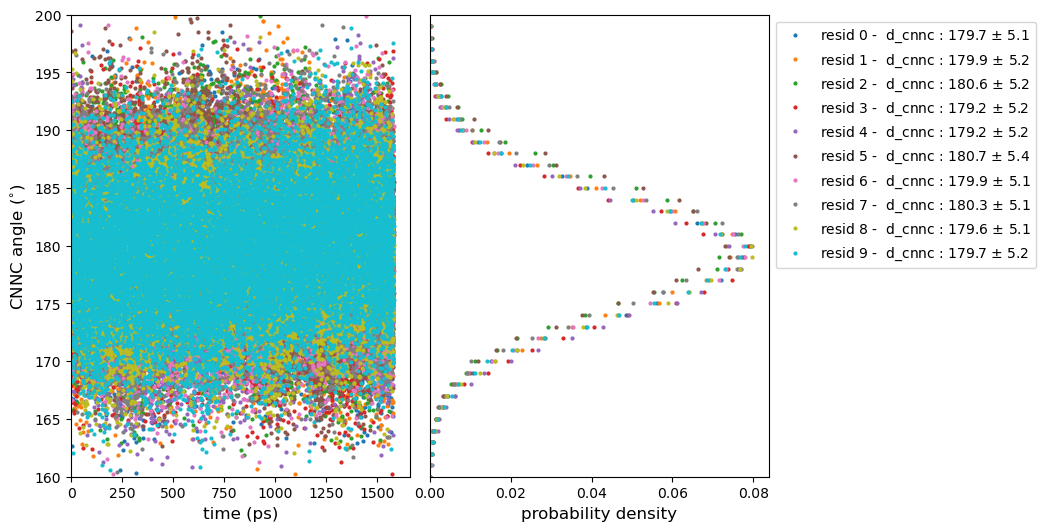

In [62]:
# CNNC

tor = "d_cnnc"
GEOM_NPC = trans_N.copy()
isomer = "trans"


fig, ax = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.06)
for i in GEOM_NPC:
    data = GEOM_NPC[i].copy()
    
    ax[0].plot(
        data["time"],
        data[tor],
        ".",
        ms=4.,
        label=f"resid {i} -  {tor} : {data[tor].mean():.1f} $\pm$ {data[tor].std():.1f}"
    )
    
    bins = np.arange(
            Param_cnnc[isomer]["center"] - Param_cnnc[isomer]["edge"],
            Param_cnnc[isomer]["center"] + Param_cnnc[isomer]["edge"] + Param_cnnc[isomer]["step"],
            Param_cnnc[isomer]["step"]
        )
    
    hist, _ = np.histogram(data[tor], bins=bins, density=True)
    ax[1].plot(
        hist,
        bins[:-1],
        ".",
        ms = 4.,
        label=f"resid {i} -  {tor} : {data[tor].mean():.1f} $\pm$ {data[tor].std():.1f}"
    )


ax[0].set_xlabel("time (ps)")
ax[0].set_ylabel("CNNC angle ($^{\circ}$)")
ax[0].set_ylim(160, 200)
ax[0].set_xlim(xmin=0.0)
    
ax[1].set_xlabel("probability density")
ax[1].get_yaxis().set_visible(False)
ax[1].set_ylim(160, 200)
ax[1].set_xlim(xmin=0.0)

ax[1].legend(bbox_to_anchor=(1., 1.), fontsize=10, loc="upper left")

save_fig("{}_{}pc_pboh_cnnc.png".format(isomer, len(GEOM_NPC)), "../figures/")
plt.show()

#### Dihedrals CCNN

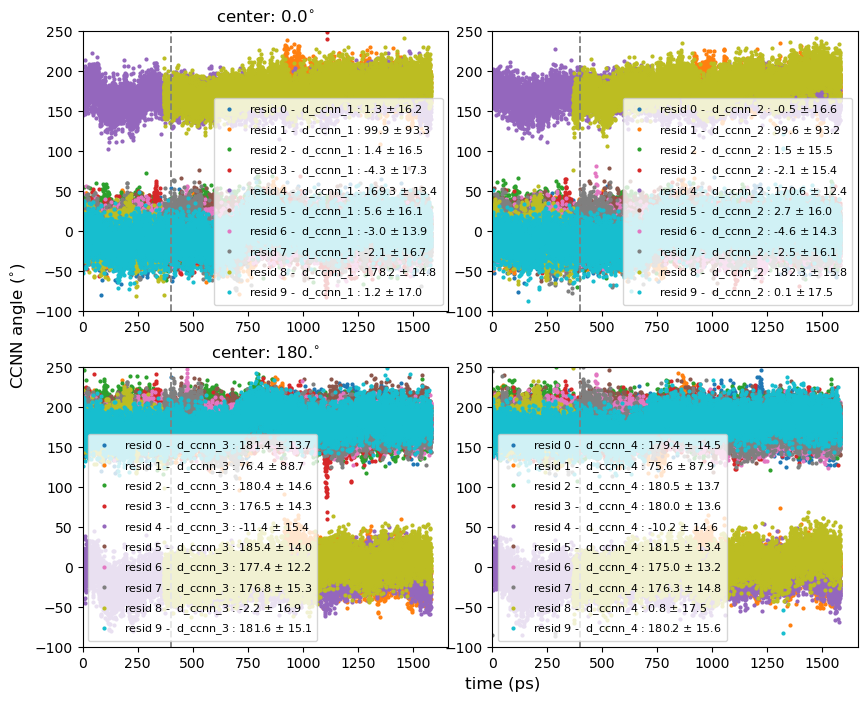

In [63]:
# CNNC

GEOM_NPC = trans_N.copy()
isomer = "trans"

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.12)


titles = [
    "center: 0.0$^{\circ}$",
    "center: 180.$^{\circ}$"
]

dihedrals = [
    ["d_ccnn_1", "d_ccnn_2"],
    ["d_ccnn_3", "d_ccnn_4"]
]

for i, title in enumerate(titles):
    ax[i, 0].set_title(title)
    row_dih = dihedrals[i]
    for j, tor in enumerate(row_dih):
        for n in GEOM_NPC:
            data = GEOM_NPC[n].copy()
            ax[i, j].plot(
                data["time"], data[tor],
                ".",
                ms = 4.,
                label="resid {} -  {} : {:.1f} $\pm$ {:.1f}".format(n, tor, data[data["time"] > 400.][tor].mean(), data[data["time"] > 400.][tor].std())
            )
        ax[i, j].legend(fontsize=8.)
        ax[i, j].set_xlim(xmin=0.0)
        ax[i, j].set_ylim(-100., 250)
        ax[i, j].axvline(x=400., ls="--", lw=1.3, color="gray")
        
    
ax[1, 0].set_xlabel("time (ps)", x=1.15)
ax[1, 0].set_ylabel("CCNN angle ($^{\circ}$)", y=1.15)

# ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.3, 0.8))

# save_fig("trans_5pc_pboh_ccnn.png", "../figures/")

save_fig("{}_{}pc_pboh_ccnn.png".format(isomer, len(GEOM_NPC)), "../figures/")
plt.show()

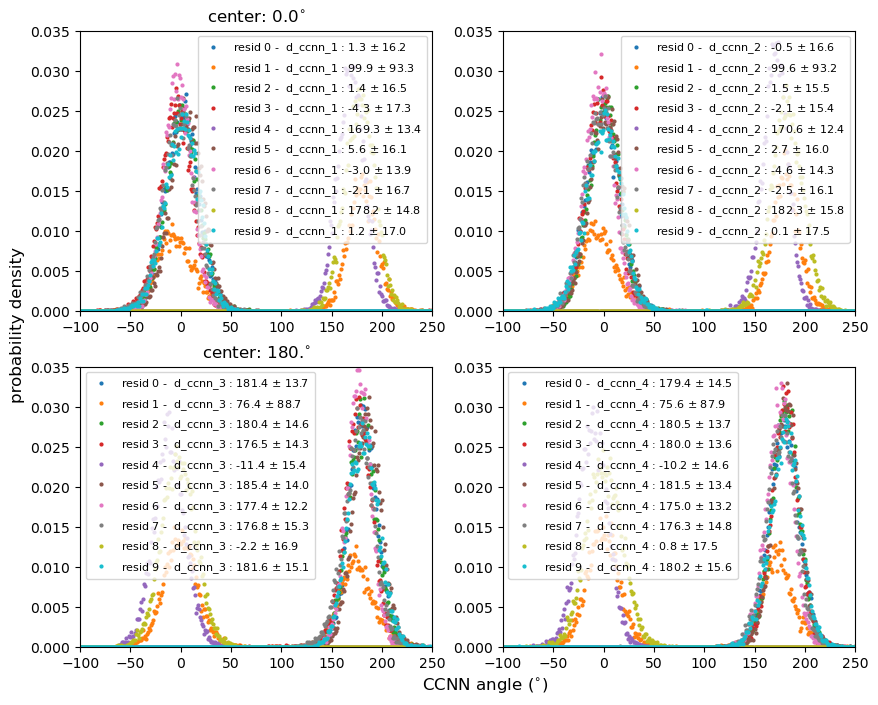

In [64]:
# CNNC

GEOM_NPC = trans_N.copy()
isomer = "trans"

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.2)

bins = np.arange(
            Param_ccnn[isomer]["center"] - Param_ccnn[isomer]["edge"],
            Param_ccnn[isomer]["center"] + Param_ccnn[isomer]["edge"] + Param_ccnn[isomer]["step"],
            Param_ccnn[isomer]["step"]
        )


titles = [
    "center: 0.0$^{\circ}$",
    "center: 180.$^{\circ}$"
]

dihedrals = [
    ["d_ccnn_1", "d_ccnn_2"],
    ["d_ccnn_3", "d_ccnn_4"]
]

for i, title in enumerate(titles):
    ax[i, 0].set_title(title)
    row_dih = dihedrals[i]
    for j, tor in enumerate(row_dih):
        for n in GEOM_NPC:
            data = GEOM_NPC[n].copy()
            hist, _ = np.histogram(data[data["time"] > 400.][tor], bins=bins, density=True)
            ax[i, j].plot(
                bins[:-1],
                hist,
                ".",
                ms = 4.,
                label="resid {} -  {} : {:.1f} $\pm$ {:.1f}".format(n, tor, data[data["time"] > 400.][tor].mean(), data[data["time"] > 400.][tor].std())
            )
        ax[i, j].legend(fontsize=8.)
        ax[i, j].set_ylim(0, 0.035)
        ax[i, j].set_xlim(-100., 250)


ax[1, 0].set_ylabel("probability density", y=1.15)
ax[1, 0].set_xlabel("CCNN angle ($^{\circ}$)", x=1.15)

# ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.3, 0.8))

save_fig("{}_{}pc_pboh_ccnn_hist.png".format(isomer, len(GEOM_NPC)), "../figures/")

plt.show()

#### Hydrogen bonds

In [65]:
isomer = "trans"
N = 10

hbonds = pd.read_csv(
    f"../exp.azob.varN/{isomer}/{N}/5_prod/hbonds_all.dat",
    header=None, sep="\s+",
    names=["frame", "n_hb"]
)

hbonds["time"] = (hbonds["frame"] - 1) * .1
hbonds = hbonds[hbonds["n_hb"] !=0]
hbonds["N"] = N
HBONDS_list.append(hbonds)

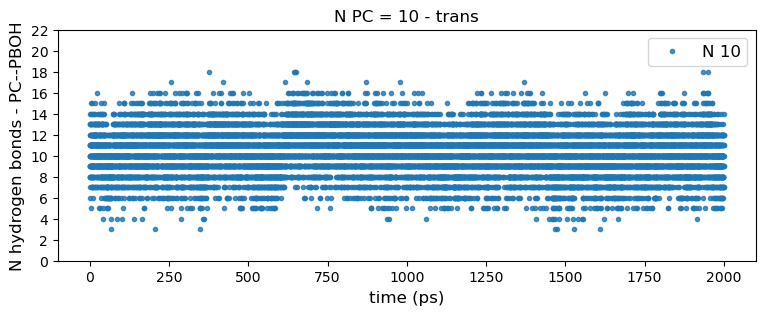

In [66]:
# CNNC

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title(f"N PC = {N} - {isomer}")
marks = ['o', 'x', '<', 's', 'D']
ax.plot(
    hbonds["time"], hbonds["n_hb"], ".",
    label="N {}".format(N),
    alpha=0.8
)

ax.set_xlabel("time (ps)")
ax.set_ylabel("N hydrogen bonds - PC--PBOH")
ax.set_yticks(range(0, 2*N+3, 2))
# ax.set_ylim(0)

ax.legend()

save_fig(f"{isomer}_{N}pc_pboh_hbonds.png", "../figures/")
plt.show()

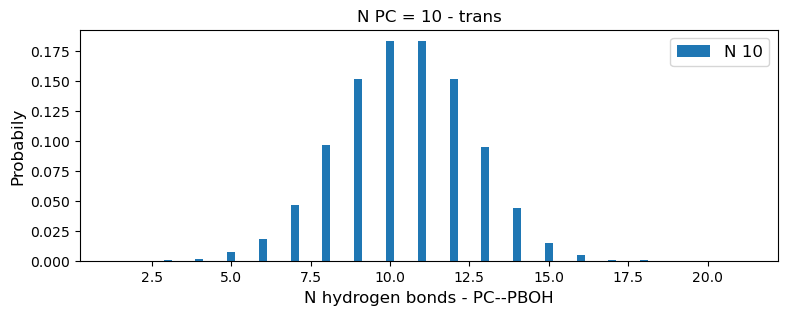

In [67]:
# CNNC

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title(f"N PC = {N} - {isomer}")
multiplier = 0
width = 0.25  # the width of the bars
# width = 1 / (len(hbonds) + 1)  # the width of the bars

data = hbonds.copy()
bins = np.arange(0, 2 * N + 3, 1)
hist, _ = np.histogram(data["n_hb"], bins=bins, density=True)    
offset = width * multiplier
rects = ax.bar(
    bins[:-1] + offset,
    hist,
    width=width,
    label="N {}".format(N)
)
# ax.bar_label(rects, padding=3)
# multiplier += 1


ax.set_ylabel("Probabily")
ax.set_xlabel("N hydrogen bonds - PC--PBOH")
ax.set_xlim(0.25, 2*N + 2+ 0.2)
# ax.set_xticks(range(0, 2*N +1 + 0.5))

ax.legend()

save_fig(f"{isomer}_{N}pc_pboh_hbonds_bars.png", "../figures/")
plt.show()

In [68]:
HBONDS = pd.concat(HBONDS_list, ignore_index=True)

Text(0, 0.5, 'N hydrogen bonds - PC--PBOH')

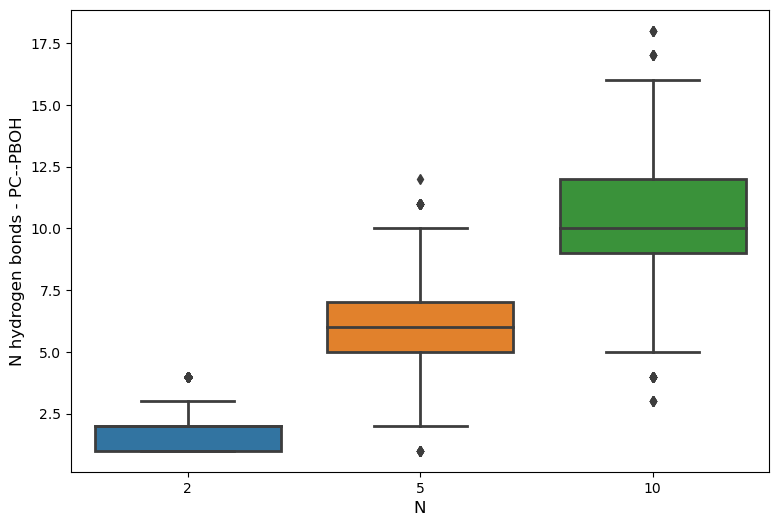

In [69]:
fig, ax = plt.subplots()
sns.boxplot(data=HBONDS, x="N", y="n_hb", ax=ax)

ax.set_ylabel("N hydrogen bonds - PC--PBOH")
# ax.legend()

#### Sizes and shape

In [70]:
isomer = "trans"
N=10
path_mol = "../exp.azob.varN/{}/{}/5_prod/molprop.csv".format(isomer, N)
sizes = pd.read_csv(f"{path_mol}")
sizes["time"] = sizes["frame"].apply(toTime, freq=0.1, t0=0.1)
sizes["Rg"] *= 0.1
sizes["dmax"] *= 0.1
sizes = sizes[sizes["idx"] > N]

SIZES[N] = sizes.copy()

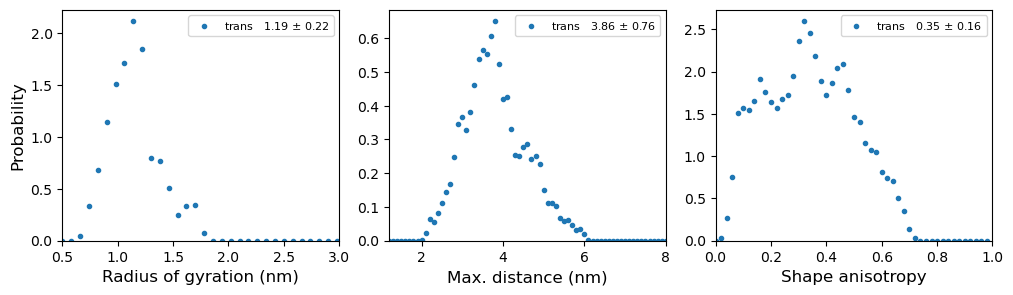

In [71]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))
fig.subplots_adjust(wspace=0.18)

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # ax[i].set_title(prop)
    formatProp = POLPROP[prop]
    
    values = sizes[prop].values
    bins = np.arange(*formatProp["bins"])
    hist, _ = np.histogram(values, bins=bins, density=True)
    ax[i].plot(
            bins[:-1],
            hist, ".", ms = 6,
            label = "{}   {:.2f} $\pm$ {:.2f}".format(isomer, values.mean(), values.std()) # label = labels[isomer],
        )
    
    ax[i].set_xlabel(formatProp["label"])
    ax[i].set_xlim(formatProp["xlim"])
    ax[i].set_ylim(ymin=0.0)
    
    ax[i].legend(fontsize=8)
ax[0].set_ylabel("Probability")

# save_fig("{}_{}pc_pboh_sizes.png".format(isomer, N), "../figures/")
plt.show()

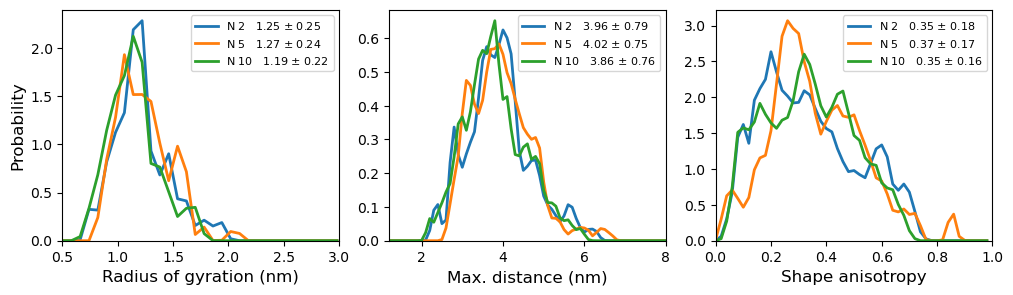

In [72]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))
fig.subplots_adjust(wspace=0.18)

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # ax[i].set_title(prop)
    formatProp = POLPROP[prop]
    
    for n in SIZES:
        sizes = SIZES[n].copy()
        values = sizes[prop].values
        bins = np.arange(*formatProp["bins"])
        hist, _ = np.histogram(values, bins=bins, density=True)
        ax[i].plot(
            bins[:-1],
            hist, "-", ms = 6,
            label = "N {}   {:.2f} $\pm$ {:.2f}".format(n, values.mean(), values.std()) # label = labels[isomer],
        )
    
    ax[i].set_xlabel(formatProp["label"])
    ax[i].set_xlim(formatProp["xlim"])
    ax[i].set_ylim(ymin=0.0)
    
    ax[i].legend(fontsize=8)
ax[0].set_ylabel("Probability")

# save_fig("{}_{}pc_pboh_sizes.png".format(isomer, N), "../figures/")
plt.show()

#### RDF all atoms

In [73]:
isomer = "trans"
N=10
path_mol = "../exp.azob.varN/{}/{}/5_prod/rdf_all_at_pc_env.csv".format(isomer, N)
rdf = pd.read_csv(path_mol)
RDFs[N] = rdf.copy()

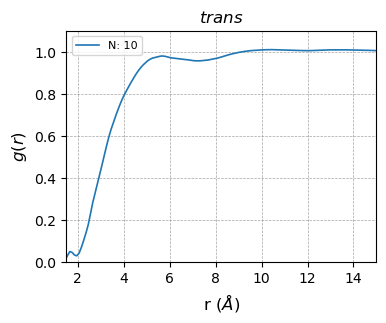

In [74]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3))

ax.set_title(labels[isomer])
ax.plot(rdf["r"], rdf["g_r"], label=f"N: {N}", ls="-", lw=1.2)

ax.set_xlim(1.5, 15.)
ax.set_ylim(0.0, 1.1)
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"$g(r)$")

ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.legend(fontsize=8)

save_fig("{}_{}pc_pboh_rdfallatoms.png".format(isomer, N), "../figures/")

plt.show()

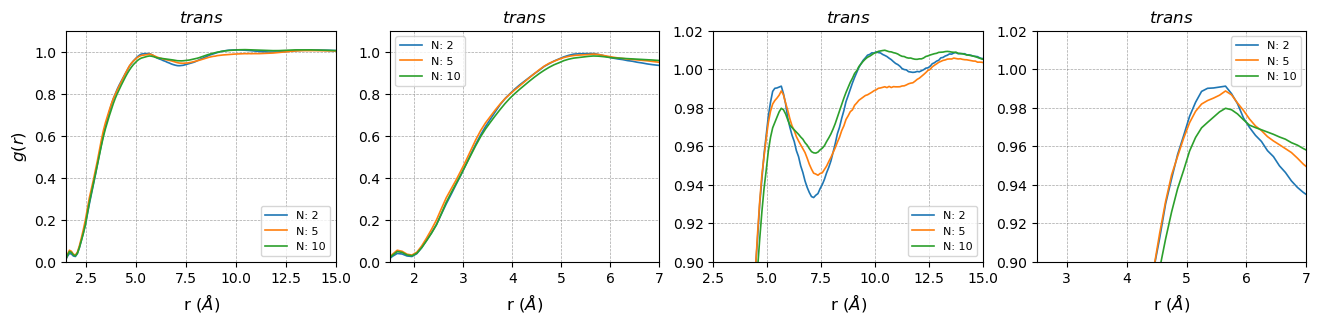

In [79]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16,3))

for i, xlim in enumerate([[1.5, 15.], [1.5, 7.], [2.5, 15.], [2.5, 7.]]):
    ax[i].set_title(labels[isomer])
    for n in RDFs:
        rdf = RDFs[n].copy()
        ax[i].plot(rdf["r"], rdf["g_r"], label=f"N: {n}", ls="-", lw=1.2)

    ax[i].set_xlim(xlim)
    if i > 1:
        ax[i].set_ylim(0.9, 1.02)
    else:
        ax[i].set_ylim(0.0, 1.1)
        
    ax[i].set_ylabel(r"$g(r)$")
    if i != 0:
        ax[i].set_ylabel("")
        
    ax[i].set_xlabel(r"r ($\AA$)")

    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax[i].legend(fontsize=8)

# save_fig("{}_{}pc_pboh_rdfallatoms.png".format(isomer, N), "../figures/")

plt.show()

### N=20

In [80]:
N = 20
isomer = "trans"
system = "5_prod"

trans_N = load_NGeom(N, isomer, system)
GEOM[N] = trans_N.copy()

#### Dihedral CNNC

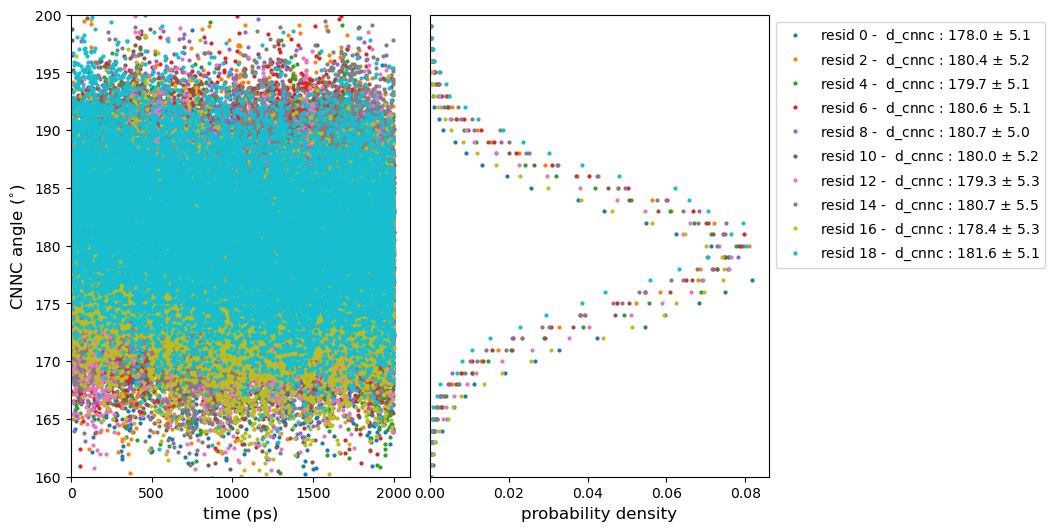

In [81]:
# CNNC

tor = "d_cnnc"
GEOM_NPC = trans_N.copy()
isomer = "trans"


fig, ax = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.06)
for i in [str(i) for i in range(0, 20, 2)]:
    data = GEOM_NPC[i].copy()
    
    ax[0].plot(
        data["time"],
        data[tor],
        ".",
        ms=4.,
        label=f"resid {i} -  {tor} : {data[tor].mean():.1f} $\pm$ {data[tor].std():.1f}"
    )
    
    bins = np.arange(
            Param_cnnc[isomer]["center"] - Param_cnnc[isomer]["edge"],
            Param_cnnc[isomer]["center"] + Param_cnnc[isomer]["edge"] + Param_cnnc[isomer]["step"],
            Param_cnnc[isomer]["step"]
        )
    
    hist, _ = np.histogram(data[tor], bins=bins, density=True)
    ax[1].plot(
        hist,
        bins[:-1],
        ".",
        ms = 4.,
        label=f"resid {i} -  {tor} : {data[tor].mean():.1f} $\pm$ {data[tor].std():.1f}"
    )


ax[0].set_xlabel("time (ps)")
ax[0].set_ylabel("CNNC angle ($^{\circ}$)")
ax[0].set_ylim(160, 200)
ax[0].set_xlim(xmin=0.0)
    
ax[1].set_xlabel("probability density")
ax[1].get_yaxis().set_visible(False)
ax[1].set_ylim(160, 200)
ax[1].set_xlim(xmin=0.0)

ax[1].legend(bbox_to_anchor=(1., 1.), fontsize=10, loc="upper left")

save_fig("{}_{}pc_pboh_cnnc.png".format(isomer, len(GEOM_NPC)), "../figures/")
plt.show()

#### Dihedrals CCNN

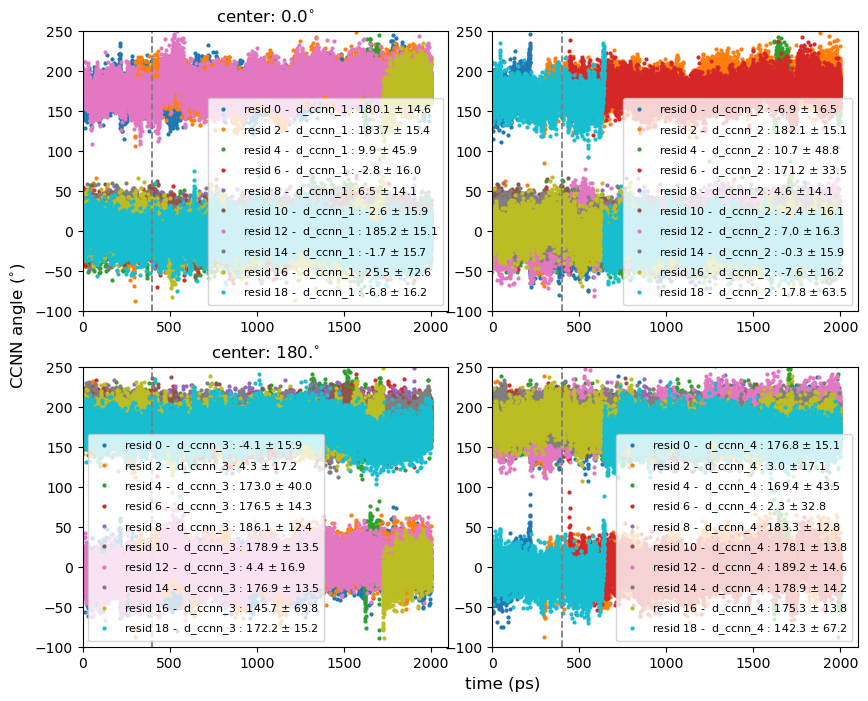

In [82]:
# CNNC

GEOM_NPC = trans_N.copy()
isomer = "trans"

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.12)


titles = [
    "center: 0.0$^{\circ}$",
    "center: 180.$^{\circ}$"
]

dihedrals = [
    ["d_ccnn_1", "d_ccnn_2"],
    ["d_ccnn_3", "d_ccnn_4"]
]

for i, title in enumerate(titles):
    ax[i, 0].set_title(title)
    row_dih = dihedrals[i]
    for j, tor in enumerate(row_dih):
        for n in [str(i) for i in range(0, 20, 2)]:
            data = GEOM_NPC[n].copy()
            ax[i, j].plot(
                data["time"], data[tor],
                ".",
                ms = 4.,
                label="resid {} -  {} : {:.1f} $\pm$ {:.1f}".format(n, tor, data[data["time"] > 400.][tor].mean(), data[data["time"] > 400.][tor].std())
            )
        ax[i, j].legend(fontsize=8.)
        ax[i, j].set_xlim(xmin=0.0)
        ax[i, j].set_ylim(-100., 250)
        ax[i, j].axvline(x=400., ls="--", lw=1.3, color="gray")
        
    
ax[1, 0].set_xlabel("time (ps)", x=1.15)
ax[1, 0].set_ylabel("CCNN angle ($^{\circ}$)", y=1.15)

# ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.3, 0.8))

# save_fig("trans_5pc_pboh_ccnn.png", "../figures/")

save_fig("{}_{}pc_pboh_ccnn.png".format(isomer, len(GEOM_NPC)), "../figures/")
plt.show()

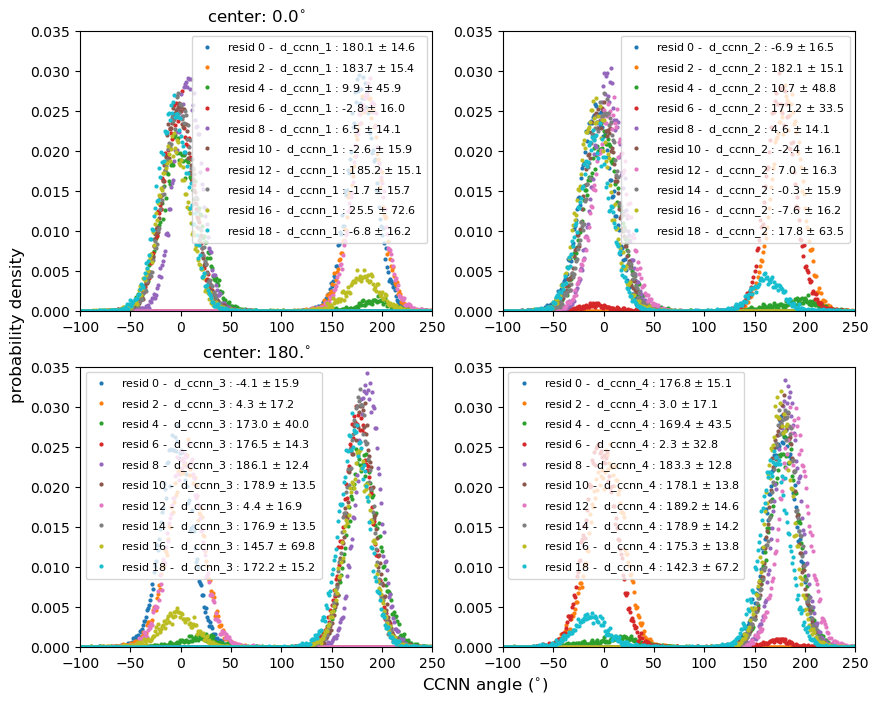

In [83]:
# CNNC

GEOM_NPC = trans_N.copy()
isomer = "trans"

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.2)

bins = np.arange(
            Param_ccnn[isomer]["center"] - Param_ccnn[isomer]["edge"],
            Param_ccnn[isomer]["center"] + Param_ccnn[isomer]["edge"] + Param_ccnn[isomer]["step"],
            Param_ccnn[isomer]["step"]
        )


titles = [
    "center: 0.0$^{\circ}$",
    "center: 180.$^{\circ}$"
]

dihedrals = [
    ["d_ccnn_1", "d_ccnn_2"],
    ["d_ccnn_3", "d_ccnn_4"]
]

for i, title in enumerate(titles):
    ax[i, 0].set_title(title)
    row_dih = dihedrals[i]
    for j, tor in enumerate(row_dih):
        for n in [str(i) for i in range(0, 20, 2)]:
            data = GEOM_NPC[n].copy()
            hist, _ = np.histogram(data[data["time"] > 400.][tor], bins=bins, density=True)
            ax[i, j].plot(
                bins[:-1],
                hist,
                ".",
                ms = 4.,
                label="resid {} -  {} : {:.1f} $\pm$ {:.1f}".format(n, tor, data[data["time"] > 400.][tor].mean(), data[data["time"] > 400.][tor].std())
            )
        ax[i, j].legend(fontsize=8.)
        ax[i, j].set_ylim(0, 0.035)
        ax[i, j].set_xlim(-100., 250)


ax[1, 0].set_ylabel("probability density", y=1.15)
ax[1, 0].set_xlabel("CCNN angle ($^{\circ}$)", x=1.15)

# ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.3, 0.8))

save_fig("{}_{}pc_pboh_ccnn_hist.png".format(isomer, len(GEOM_NPC)), "../figures/")

plt.show()

#### Hydrogen bonds

In [84]:
isomer = "trans"
N = 20

hbonds = pd.read_csv(
    f"../exp.azob.varN/{isomer}/{N}/5_prod/hbonds_all.dat",
    header=None, sep="\s+",
    names=["frame", "n_hb"]
)

hbonds["time"] = (hbonds["frame"] - 1) * .1
hbonds = hbonds[hbonds["n_hb"] !=0]
hbonds["N"] = N
HBONDS_list.append(hbonds)

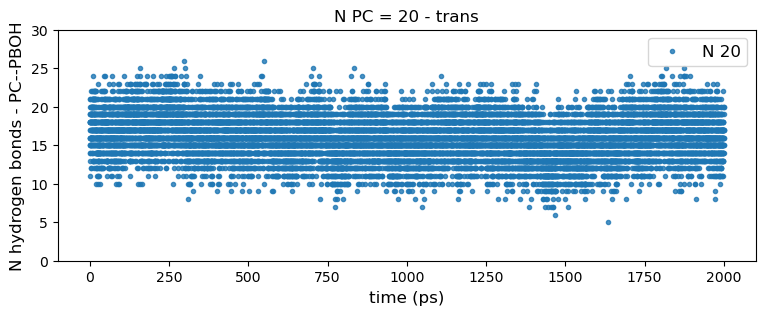

In [85]:
# CNNC

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title(f"N PC = {N} - {isomer}")
marks = ['o', 'x', '<', 's', 'D']
ax.plot(
    hbonds["time"], hbonds["n_hb"], ".",
    label="N {}".format(N),
    alpha=0.8
)

ax.set_xlabel("time (ps)")
ax.set_ylabel("N hydrogen bonds - PC--PBOH")
ax.set_yticks(range(0, 2*15+5, 5))
# ax.set_ylim(0)

ax.legend()

save_fig(f"{isomer}_{N}pc_pboh_hbonds.png", "../figures/")
plt.show()

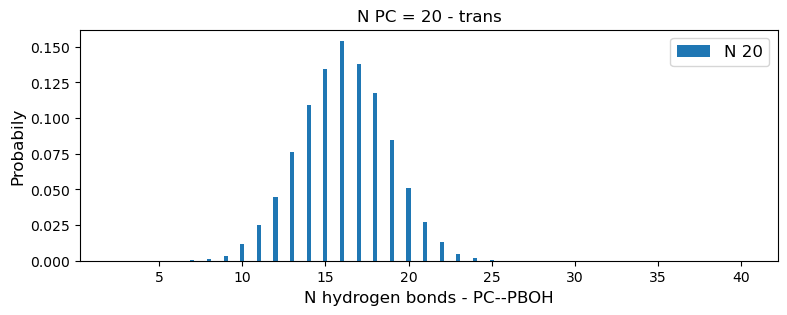

In [86]:
# CNNC

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title(f"N PC = {N} - {isomer}")
multiplier = 0
width = 0.25  # the width of the bars
# width = 1 / (len(hbonds) + 1)  # the width of the bars

data = hbonds.copy()
bins = np.arange(0, 2 * N + 3, 1)
hist, _ = np.histogram(data["n_hb"], bins=bins, density=True)    
offset = width * multiplier
rects = ax.bar(
    bins[:-1] + offset,
    hist,
    width=width,
    label="N {}".format(N)
)
# ax.bar_label(rects, padding=3)
# multiplier += 1


ax.set_ylabel("Probabily")
ax.set_xlabel("N hydrogen bonds - PC--PBOH")
ax.set_xlim(0.25, 2*N + 2+ 0.2)
# ax.set_xticks(range(0, 2*N +1 + 0.5))

ax.legend()

save_fig(f"{isomer}_{N}pc_pboh_hbonds_bars.png", "../figures/")
plt.show()

In [87]:
HBONDS = pd.concat(HBONDS_list, ignore_index=True)

Text(0, 0.5, 'N hydrogen bonds - PC--PBOH')

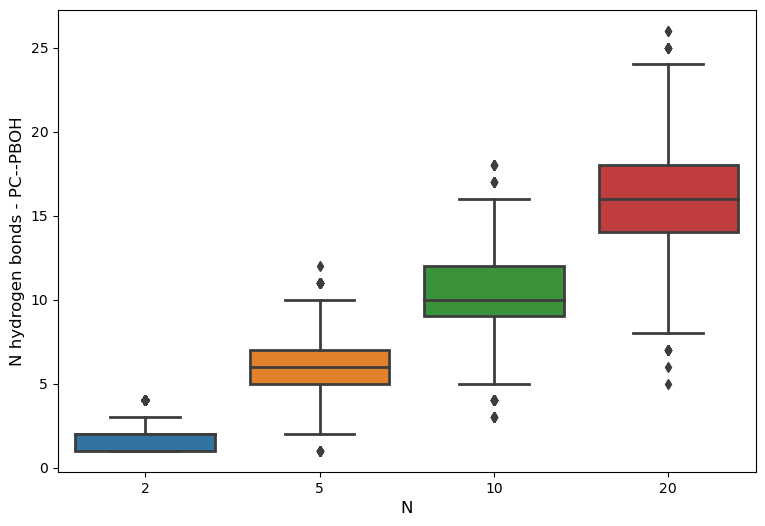

In [90]:
fig, ax = plt.subplots()
# sns.violinplot(data=HBONDS, x="N", y="n_hb", split=True, inner="quart", ax=ax)
sns.boxplot(data=HBONDS, x="N", y="n_hb", ax=ax)

ax.set_ylabel("N hydrogen bonds - PC--PBOH")
# ax.legend()

#### Sizes and shape

In [91]:
isomer = "trans"
N=20
path_mol = "../exp.azob.varN/{}/{}/5_prod/molprop.csv".format(isomer, N)
sizes = pd.read_csv(f"{path_mol}")
sizes["time"] = sizes["frame"].apply(toTime, freq=0.1, t0=0.1)
sizes["Rg"] *= 0.1
sizes["dmax"] *= 0.1
sizes = sizes[sizes["idx"] > N]

SIZES[N] = sizes.copy()

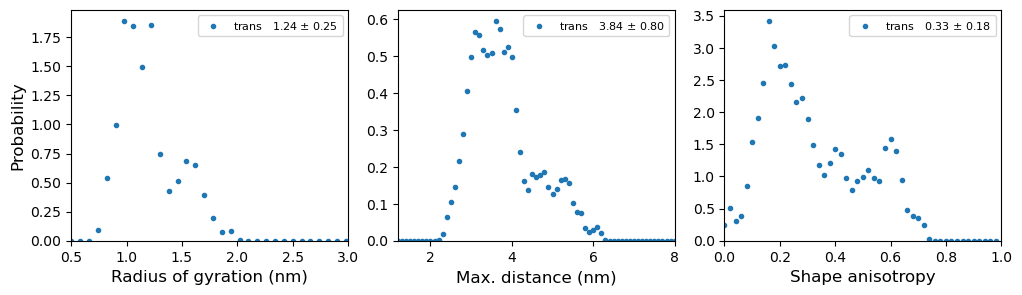

In [92]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))
fig.subplots_adjust(wspace=0.18)

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # ax[i].set_title(prop)
    formatProp = POLPROP[prop]
    
    values = sizes[prop].values
    bins = np.arange(*formatProp["bins"])
    hist, _ = np.histogram(values, bins=bins, density=True)
    ax[i].plot(
            bins[:-1],
            hist, ".", ms = 6,
            label = "{}   {:.2f} $\pm$ {:.2f}".format(isomer, values.mean(), values.std()) # label = labels[isomer],
        )
    
    ax[i].set_xlabel(formatProp["label"])
    ax[i].set_xlim(formatProp["xlim"])
    ax[i].set_ylim(ymin=0.0)
    
    ax[i].legend(fontsize=8)
ax[0].set_ylabel("Probability")

# save_fig("{}_{}pc_pboh_sizes.png".format(isomer, N), "../figures/")
plt.show()

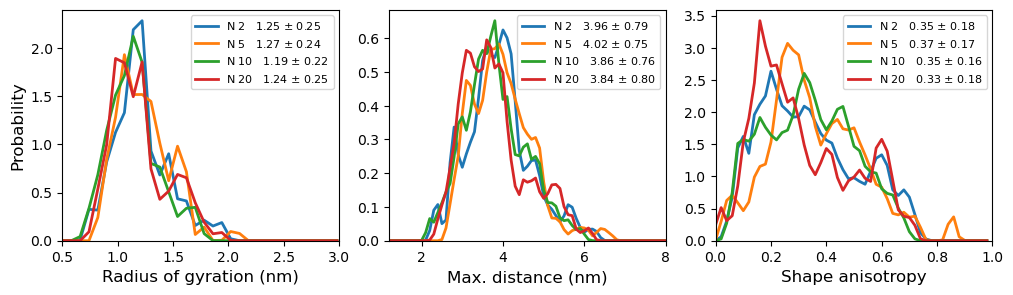

In [93]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))
fig.subplots_adjust(wspace=0.18)

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # ax[i].set_title(prop)
    formatProp = POLPROP[prop]
    
    for n in SIZES:
        sizes = SIZES[n].copy()
        values = sizes[prop].values
        bins = np.arange(*formatProp["bins"])
        hist, _ = np.histogram(values, bins=bins, density=True)
        ax[i].plot(
            bins[:-1],
            hist, "-", ms = 6,
            label = "N {}   {:.2f} $\pm$ {:.2f}".format(n, values.mean(), values.std()) # label = labels[isomer],
        )
    
    ax[i].set_xlabel(formatProp["label"])
    ax[i].set_xlim(formatProp["xlim"])
    ax[i].set_ylim(ymin=0.0)
    
    ax[i].legend(fontsize=8)
ax[0].set_ylabel("Probability")

# save_fig("{}_{}pc_pboh_sizes.png".format(isomer, N), "../figures/")
plt.show()

In [94]:
SIZESall = []
for n in SIZES:
    data = SIZES[n].copy()
    data["N"] = n
    SIZESall.append(data)
    
SIZESall = pd.concat(SIZESall, ignore_index=True)

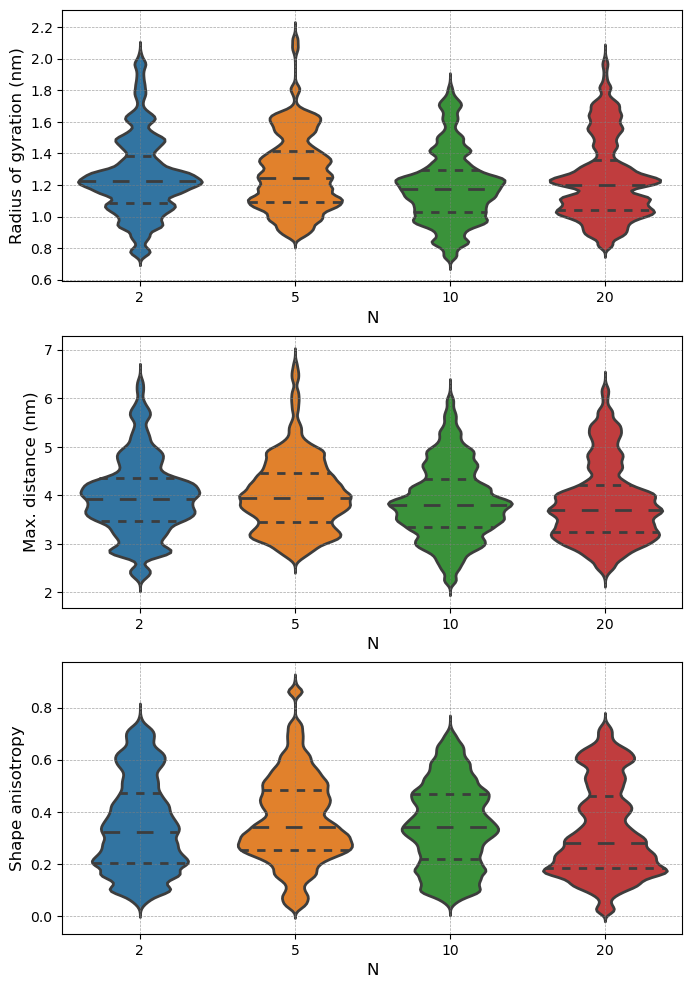

In [101]:
fig, ax = plt.subplots(nrows=3, figsize=(8,12))

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    sns.violinplot(data=SIZESall, x="N", y=prop, split=True, inner="quart", ax=ax[i])
    ax[i].set_ylabel(POLPROP[prop]["label"])
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
# ax.legend()

#### RDF all atoms

In [102]:
isomer = "trans"
N=20
path_mol = "../exp.azob.varN/{}/{}/5_prod/rdf_all_at_pc_env.csv".format(isomer, N)
rdf = pd.read_csv(path_mol)
RDFs[N] = rdf.copy()

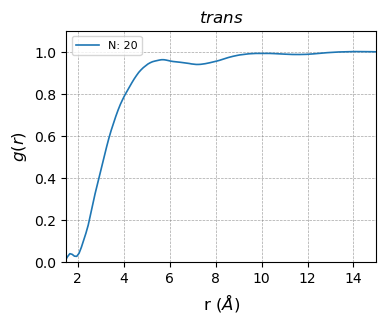

In [103]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3))

ax.set_title(labels[isomer])
ax.plot(rdf["r"], rdf["g_r"], label=f"N: {N}", ls="-", lw=1.2)

ax.set_xlim(1.5, 15.)
ax.set_ylim(0.0, 1.1)
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"$g(r)$")

ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.legend(fontsize=8)

save_fig("{}_{}pc_pboh_rdfallatoms.png".format(isomer, N), "../figures/")

plt.show()

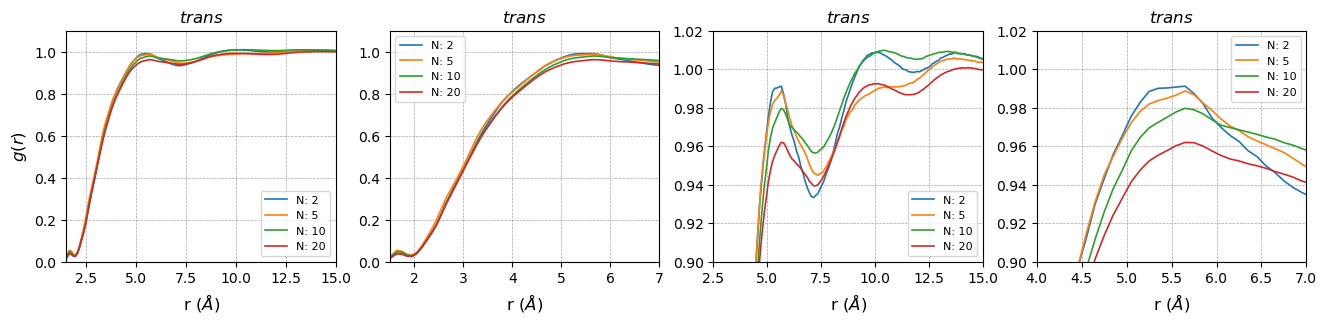

In [106]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16,3))

for i, xlim in enumerate([[1.5, 15.], [1.5, 7.], [2.5, 15.], [4., 7.]]):
    ax[i].set_title(labels[isomer])
    for n in RDFs:
        rdf = RDFs[n].copy()
        ax[i].plot(rdf["r"], rdf["g_r"], label=f"N: {n}", ls="-", lw=1.2)

    ax[i].set_xlim(xlim)
    if i > 1:
        ax[i].set_ylim(0.9, 1.02)
    else:
        ax[i].set_ylim(0.0, 1.1)
        
    ax[i].set_ylabel(r"$g(r)$")
    if i != 0:
        ax[i].set_ylabel("")
        
    ax[i].set_xlabel(r"r ($\AA$)")

    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax[i].legend(fontsize=8)

# save_fig("{}_{}pc_pboh_rdfallatoms.png".format(isomer, N), "../figures/")

plt.show()

### N=50

In [107]:
N = 50
isomer = "trans"
system = "5_prod"

trans_N = load_NGeom(N, isomer, system)
GEOM[N] = trans_N.copy()

FileNotFoundError: [Errno 2] No such file or directory: '../exp.azob.varN/trans/50/5_prod/Geometry_mol_0.csv'

#### Dihedral CNNC

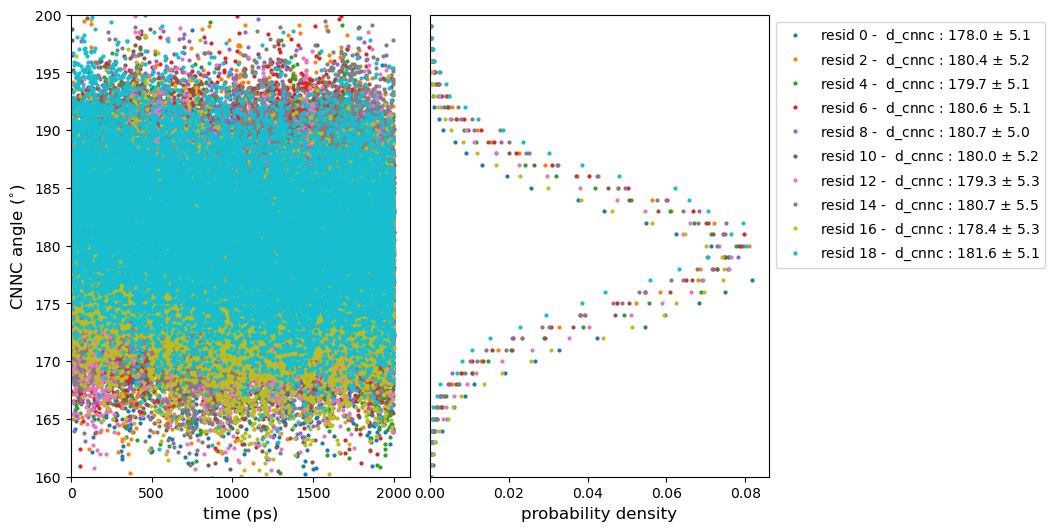

In [81]:
# CNNC

tor = "d_cnnc"
GEOM_NPC = trans_N.copy()
isomer = "trans"


fig, ax = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.06)
for i in [str(i) for i in range(0, 20, 2)]:
    data = GEOM_NPC[i].copy()
    
    ax[0].plot(
        data["time"],
        data[tor],
        ".",
        ms=4.,
        label=f"resid {i} -  {tor} : {data[tor].mean():.1f} $\pm$ {data[tor].std():.1f}"
    )
    
    bins = np.arange(
            Param_cnnc[isomer]["center"] - Param_cnnc[isomer]["edge"],
            Param_cnnc[isomer]["center"] + Param_cnnc[isomer]["edge"] + Param_cnnc[isomer]["step"],
            Param_cnnc[isomer]["step"]
        )
    
    hist, _ = np.histogram(data[tor], bins=bins, density=True)
    ax[1].plot(
        hist,
        bins[:-1],
        ".",
        ms = 4.,
        label=f"resid {i} -  {tor} : {data[tor].mean():.1f} $\pm$ {data[tor].std():.1f}"
    )


ax[0].set_xlabel("time (ps)")
ax[0].set_ylabel("CNNC angle ($^{\circ}$)")
ax[0].set_ylim(160, 200)
ax[0].set_xlim(xmin=0.0)
    
ax[1].set_xlabel("probability density")
ax[1].get_yaxis().set_visible(False)
ax[1].set_ylim(160, 200)
ax[1].set_xlim(xmin=0.0)

ax[1].legend(bbox_to_anchor=(1., 1.), fontsize=10, loc="upper left")

save_fig("{}_{}pc_pboh_cnnc.png".format(isomer, len(GEOM_NPC)), "../figures/")
plt.show()

#### Dihedrals CCNN

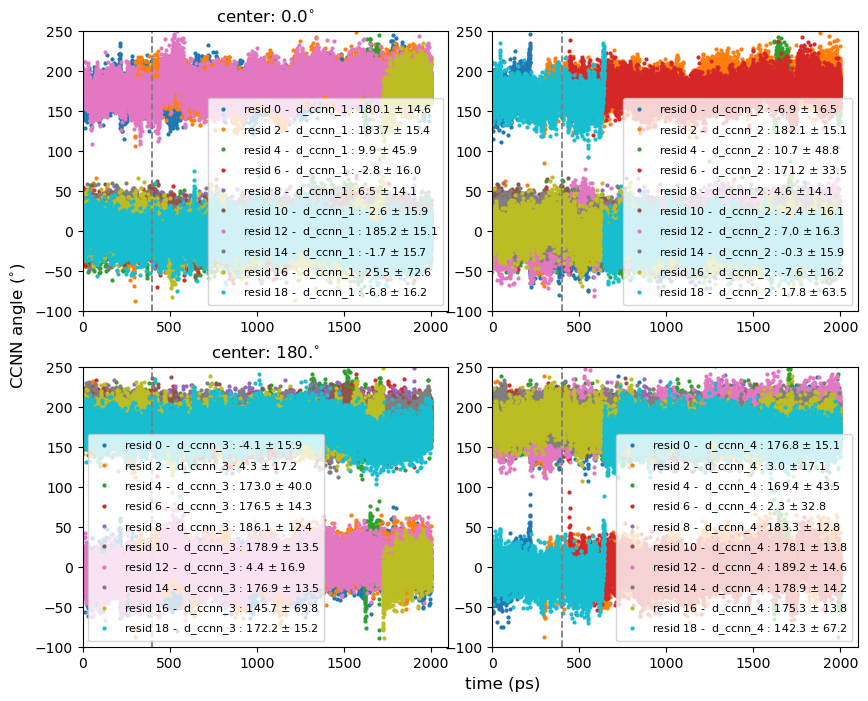

In [82]:
# CNNC

GEOM_NPC = trans_N.copy()
isomer = "trans"

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.12)


titles = [
    "center: 0.0$^{\circ}$",
    "center: 180.$^{\circ}$"
]

dihedrals = [
    ["d_ccnn_1", "d_ccnn_2"],
    ["d_ccnn_3", "d_ccnn_4"]
]

for i, title in enumerate(titles):
    ax[i, 0].set_title(title)
    row_dih = dihedrals[i]
    for j, tor in enumerate(row_dih):
        for n in [str(i) for i in range(0, 20, 2)]:
            data = GEOM_NPC[n].copy()
            ax[i, j].plot(
                data["time"], data[tor],
                ".",
                ms = 4.,
                label="resid {} -  {} : {:.1f} $\pm$ {:.1f}".format(n, tor, data[data["time"] > 400.][tor].mean(), data[data["time"] > 400.][tor].std())
            )
        ax[i, j].legend(fontsize=8.)
        ax[i, j].set_xlim(xmin=0.0)
        ax[i, j].set_ylim(-100., 250)
        ax[i, j].axvline(x=400., ls="--", lw=1.3, color="gray")
        
    
ax[1, 0].set_xlabel("time (ps)", x=1.15)
ax[1, 0].set_ylabel("CCNN angle ($^{\circ}$)", y=1.15)

# ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.3, 0.8))

# save_fig("trans_5pc_pboh_ccnn.png", "../figures/")

save_fig("{}_{}pc_pboh_ccnn.png".format(isomer, len(GEOM_NPC)), "../figures/")
plt.show()

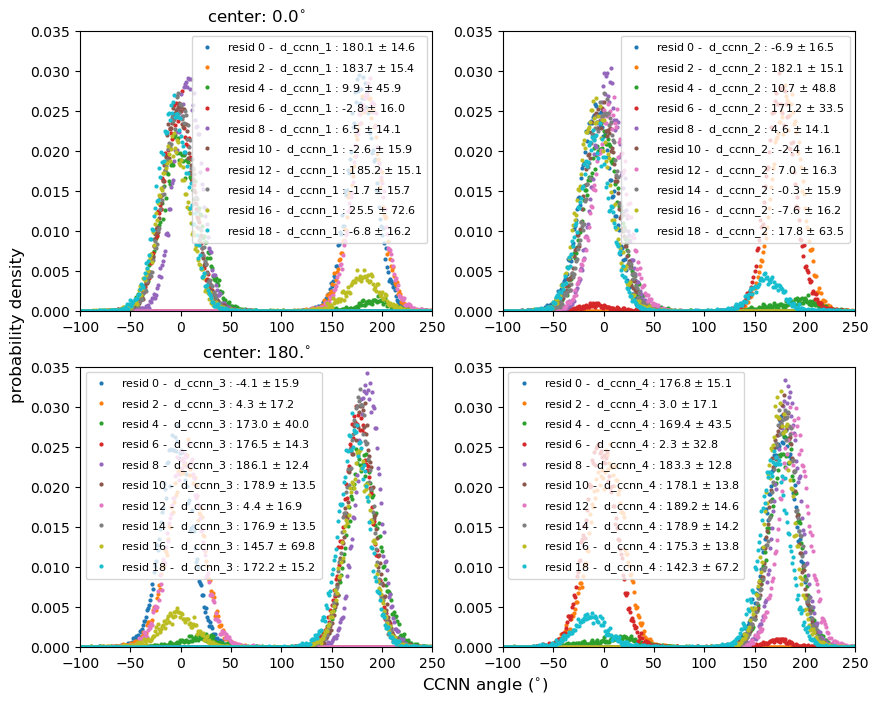

In [83]:
# CNNC

GEOM_NPC = trans_N.copy()
isomer = "trans"

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.2)

bins = np.arange(
            Param_ccnn[isomer]["center"] - Param_ccnn[isomer]["edge"],
            Param_ccnn[isomer]["center"] + Param_ccnn[isomer]["edge"] + Param_ccnn[isomer]["step"],
            Param_ccnn[isomer]["step"]
        )


titles = [
    "center: 0.0$^{\circ}$",
    "center: 180.$^{\circ}$"
]

dihedrals = [
    ["d_ccnn_1", "d_ccnn_2"],
    ["d_ccnn_3", "d_ccnn_4"]
]

for i, title in enumerate(titles):
    ax[i, 0].set_title(title)
    row_dih = dihedrals[i]
    for j, tor in enumerate(row_dih):
        for n in [str(i) for i in range(0, 20, 2)]:
            data = GEOM_NPC[n].copy()
            hist, _ = np.histogram(data[data["time"] > 400.][tor], bins=bins, density=True)
            ax[i, j].plot(
                bins[:-1],
                hist,
                ".",
                ms = 4.,
                label="resid {} -  {} : {:.1f} $\pm$ {:.1f}".format(n, tor, data[data["time"] > 400.][tor].mean(), data[data["time"] > 400.][tor].std())
            )
        ax[i, j].legend(fontsize=8.)
        ax[i, j].set_ylim(0, 0.035)
        ax[i, j].set_xlim(-100., 250)


ax[1, 0].set_ylabel("probability density", y=1.15)
ax[1, 0].set_xlabel("CCNN angle ($^{\circ}$)", x=1.15)

# ax[0, 1].legend(loc="upper center", bbox_to_anchor=(1.3, 0.8))

save_fig("{}_{}pc_pboh_ccnn_hist.png".format(isomer, len(GEOM_NPC)), "../figures/")

plt.show()

#### Hydrogen bonds

In [122]:
isomer = "trans"
N = 50

hbonds = pd.read_csv(
    f"../exp.azob.varN/{isomer}/{N}/5_prod/hbonds_all.dat",
    header=None, sep="\s+",
    names=["frame", "n_hb"]
)

hbonds["time"] = (hbonds["frame"] - 1) * .1
hbonds = hbonds[hbonds["n_hb"] !=0]
hbonds["N"] = N
HBONDS_list.append(hbonds)

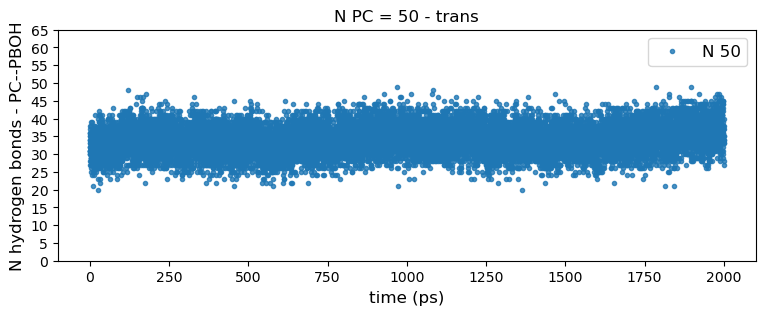

In [125]:
# CNNC

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title(f"N PC = {N} - {isomer}")
marks = ['o', 'x', '<', 's', 'D']
ax.plot(
    hbonds["time"], hbonds["n_hb"], ".",
    label="N {}".format(N),
    alpha=0.8
)

ax.set_xlabel("time (ps)")
ax.set_ylabel("N hydrogen bonds - PC--PBOH")
ax.set_yticks(range(0, 2*N-30, 5))
# ax.set_ylim(0)

ax.legend()

save_fig(f"{isomer}_{N}pc_pboh_hbonds.png", "../figures/")
plt.show()

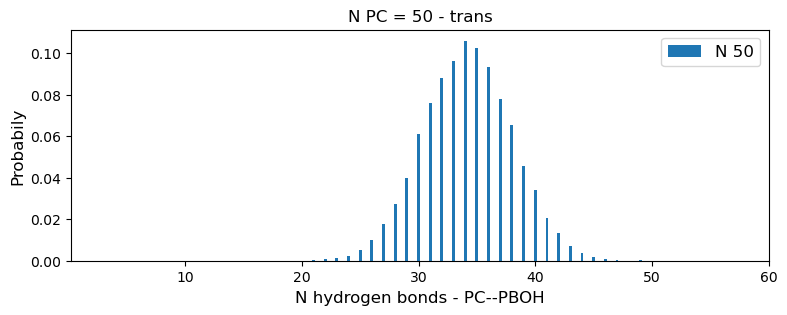

In [127]:
# CNNC

fig, ax = plt.subplots(figsize=(9, 3))

ax.set_title(f"N PC = {N} - {isomer}")
multiplier = 0
width = 0.25  # the width of the bars
# width = 1 / (len(hbonds) + 1)  # the width of the bars

data = hbonds.copy()
bins = np.arange(0, 2 * N + 3, 1)
hist, _ = np.histogram(data["n_hb"], bins=bins, density=True)    
offset = width * multiplier
rects = ax.bar(
    bins[:-1] + offset,
    hist,
    width=width,
    label="N {}".format(N)
)
# ax.bar_label(rects, padding=3)
# multiplier += 1


ax.set_ylabel("Probabily")
ax.set_xlabel("N hydrogen bonds - PC--PBOH")
ax.set_xlim(0.25, 2*N + -40)
# ax.set_xticks(range(0, 2*N +1 + 0.5))

ax.legend()

save_fig(f"{isomer}_{N}pc_pboh_hbonds_bars.png", "../figures/")
plt.show()

In [128]:
HBONDS = pd.concat(HBONDS_list, ignore_index=True)

Text(0, 0.5, 'N hydrogen bonds - PC--PBOH')

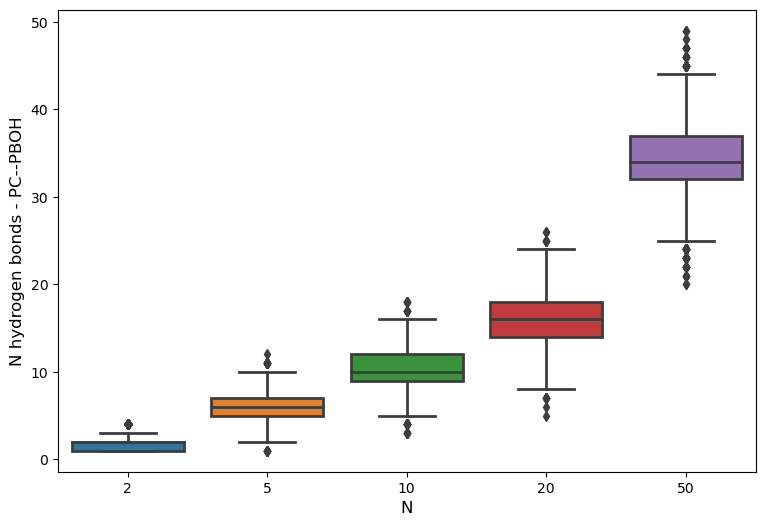

In [129]:
fig, ax = plt.subplots()
# sns.violinplot(data=HBONDS, x="N", y="n_hb", split=True, inner="quart", ax=ax)
sns.boxplot(data=HBONDS, x="N", y="n_hb", ax=ax)

ax.set_ylabel("N hydrogen bonds - PC--PBOH")
# ax.legend()

#### Sizes and shape

In [130]:
isomer = "trans"
N=50
path_mol = "../exp.azob.varN/{}/{}/5_prod/molprop.csv".format(isomer, N)
sizes = pd.read_csv(f"{path_mol}")
sizes["time"] = sizes["frame"].apply(toTime, freq=0.1, t0=0.1)
sizes["Rg"] *= 0.1
sizes["dmax"] *= 0.1
sizes = sizes[sizes["idx"] > N]

SIZES[N] = sizes.copy()

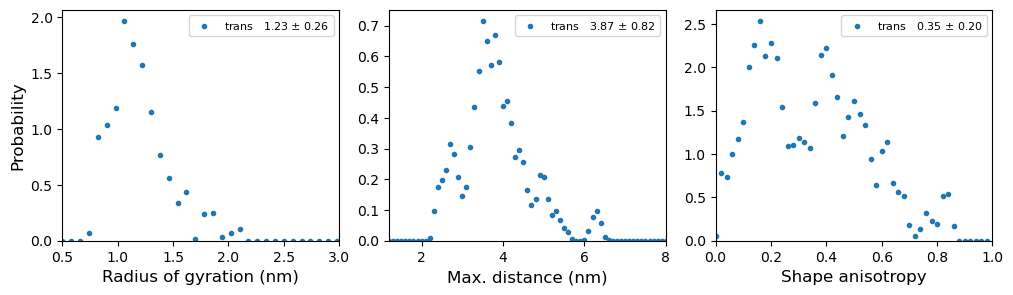

In [131]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))
fig.subplots_adjust(wspace=0.18)

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # ax[i].set_title(prop)
    formatProp = POLPROP[prop]
    
    values = sizes[prop].values
    bins = np.arange(*formatProp["bins"])
    hist, _ = np.histogram(values, bins=bins, density=True)
    ax[i].plot(
            bins[:-1],
            hist, ".", ms = 6,
            label = "{}   {:.2f} $\pm$ {:.2f}".format(isomer, values.mean(), values.std()) # label = labels[isomer],
        )
    
    ax[i].set_xlabel(formatProp["label"])
    ax[i].set_xlim(formatProp["xlim"])
    ax[i].set_ylim(ymin=0.0)
    
    ax[i].legend(fontsize=8)
ax[0].set_ylabel("Probability")

# save_fig("{}_{}pc_pboh_sizes.png".format(isomer, N), "../figures/")
plt.show()

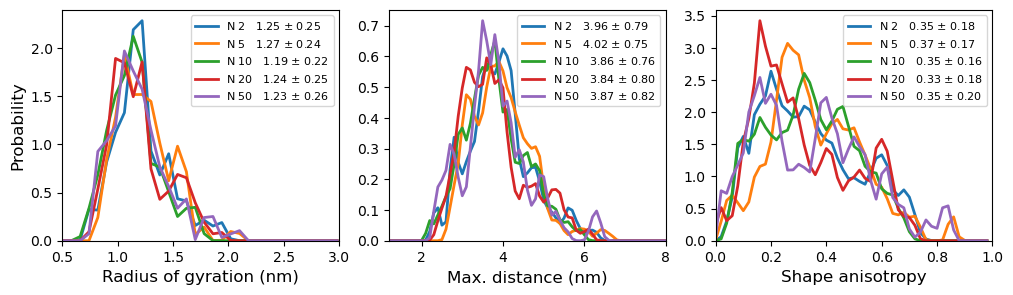

In [132]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,3))
fig.subplots_adjust(wspace=0.18)

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # ax[i].set_title(prop)
    formatProp = POLPROP[prop]
    
    for n in SIZES:
        sizes = SIZES[n].copy()
        values = sizes[prop].values
        bins = np.arange(*formatProp["bins"])
        hist, _ = np.histogram(values, bins=bins, density=True)
        ax[i].plot(
            bins[:-1],
            hist, "-", ms = 6,
            label = "N {}   {:.2f} $\pm$ {:.2f}".format(n, values.mean(), values.std()) # label = labels[isomer],
        )
    
    ax[i].set_xlabel(formatProp["label"])
    ax[i].set_xlim(formatProp["xlim"])
    ax[i].set_ylim(ymin=0.0)
    
    ax[i].legend(fontsize=8)
ax[0].set_ylabel("Probability")

# save_fig("{}_{}pc_pboh_sizes.png".format(isomer, N), "../figures/")
plt.show()

In [133]:
SIZESall = []
for n in SIZES:
    data = SIZES[n].copy()
    data["N"] = n
    SIZESall.append(data)
    
SIZESall = pd.concat(SIZESall, ignore_index=True)

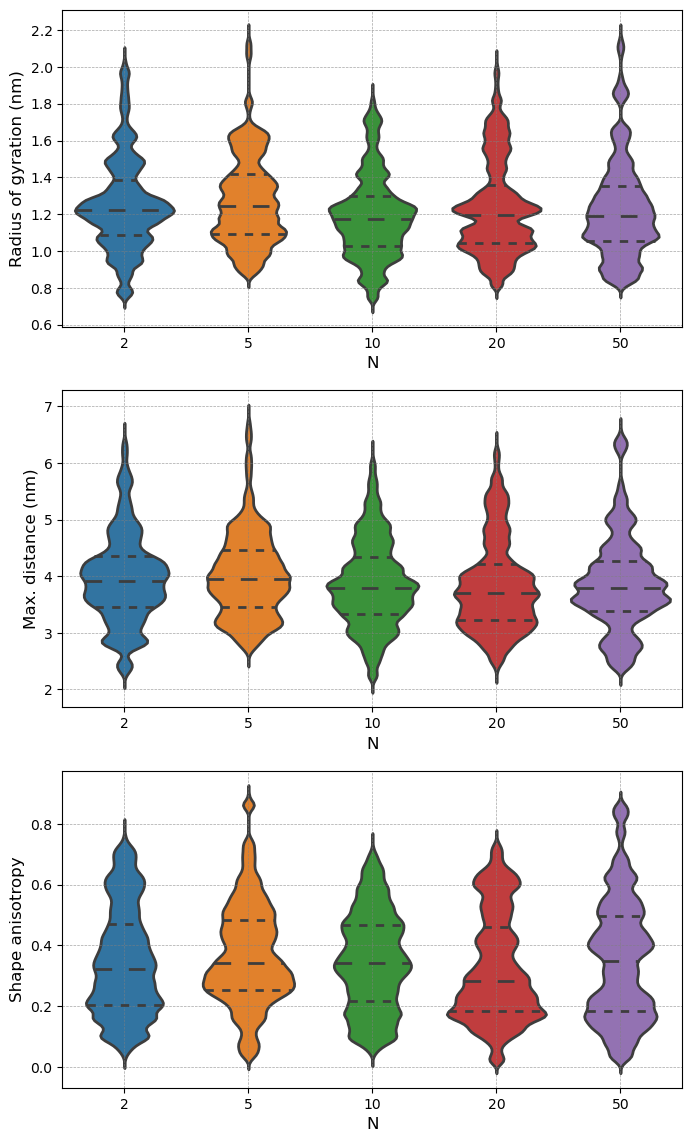

In [134]:
fig, ax = plt.subplots(nrows=3, figsize=(8,14))

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    sns.violinplot(data=SIZESall, x="N", y=prop, split=True, inner="quart", ax=ax[i])
    ax[i].set_ylabel(POLPROP[prop]["label"])
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
# ax.legend()

#### RDF all atoms

In [135]:
isomer = "trans"
N=50
path_mol = "../exp.azob.varN/{}/{}/5_prod/rdf_all_at_pc_env.csv".format(isomer, N)
rdf = pd.read_csv(path_mol)
RDFs[N] = rdf.copy()

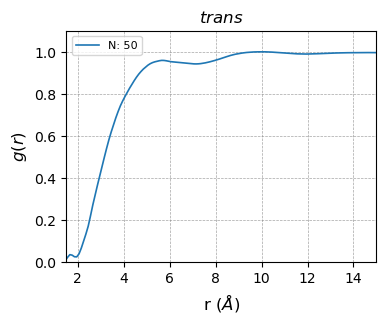

In [136]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3))

ax.set_title(labels[isomer])
ax.plot(rdf["r"], rdf["g_r"], label=f"N: {N}", ls="-", lw=1.2)

ax.set_xlim(1.5, 15.)
ax.set_ylim(0.0, 1.1)
ax.set_xlabel(r"r ($\AA$)")
ax.set_ylabel(r"$g(r)$")

ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.legend(fontsize=8)

save_fig("{}_{}pc_pboh_rdfallatoms.png".format(isomer, N), "../figures/")

plt.show()

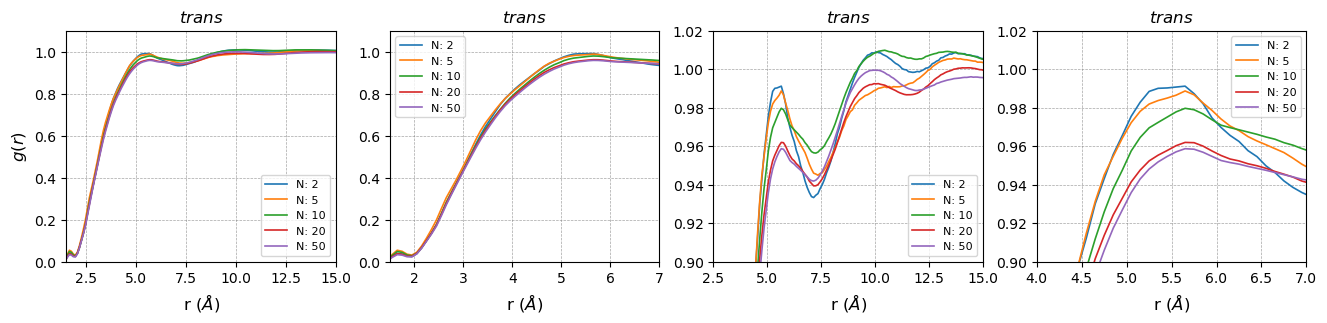

In [137]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16,3))

for i, xlim in enumerate([[1.5, 15.], [1.5, 7.], [2.5, 15.], [4., 7.]]):
    ax[i].set_title(labels[isomer])
    for n in RDFs:
        rdf = RDFs[n].copy()
        ax[i].plot(rdf["r"], rdf["g_r"], label=f"N: {n}", ls="-", lw=1.2)

    ax[i].set_xlim(xlim)
    if i > 1:
        ax[i].set_ylim(0.9, 1.02)
    else:
        ax[i].set_ylim(0.0, 1.1)
        
    ax[i].set_ylabel(r"$g(r)$")
    if i != 0:
        ax[i].set_ylabel("")
        
    ax[i].set_xlabel(r"r ($\AA$)")

    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax[i].legend(fontsize=8)

# save_fig("{}_{}pc_pboh_rdfallatoms.png".format(isomer, N), "../figures/")

plt.show()

### isomer cis

## Cohesion energy

In [35]:
%%time
CED = {}
for iso in ["trans", "cis"]:
    print("ISOMER:", iso)
    CED[iso] = {}
    for N in ["0", "2", "5", "10", "20", "50"]:
        print("N PC:", N)
        if N != "0":
            donnees = f"../exp.azob.varN/{iso}/{N}/5_prod/DONNEES.in"
        else:
            donnees = f"../exp.azob.varN/pol/5_prod/DONNEES.in"
        system = STAMP(donnees, traj_type="GRO")
        
            # Data
        data = system.data.copy()
        
        # N atoms
        natoms = system.Natoms
        
        # Volume (nm3)
        vol = system.vol[-1]
        # nm3 --> m3
        vol *= 1e-27
        
        data["ced"] = -(data["Epot_inter"] / N_A / 1e-3) * natoms / vol
        data["delta"] = np.sqrt(data["ced"] * 1e-6)
        CED[iso][N] = data.copy()

ISOMER: trans
N PC: 0
Reading log file - time step detected (ps): 0.00025
Initial time detected (ps): 1.001e-09
Initial frame: 4000000
Reading fatomes file - done in 1.96 s
Searching connectivity - done in 1.91 s
Number of frames 2000
N PC: 2
Reading log file - time step detected (ps): 0.00025
Initial time detected (ps): 1.001e-09
Initial frame: 4000000
Reading fatomes file - done in 1.87 s
Searching connectivity - done in 2.06 s
Number of frames 20000
N PC: 5
Reading log file - time step detected (ps): 0.00025
Initial time detected (ps): 1.001e-09
Initial frame: 4000000
Reading fatomes file - done in 1.89 s
Searching connectivity - done in 2.11 s
Number of frames 20000
N PC: 10
Reading log file - time step detected (ps): 0.00025
Initial time detected (ps): 1.001e-09
Initial frame: 4000000
Reading fatomes file - done in 1.91 s
Searching connectivity - done in 2.14 s
Number of frames 20000
N PC: 20
Reading log file - time step detected (ps): 0.00025
Initial time detected (ps): 1.001e-09

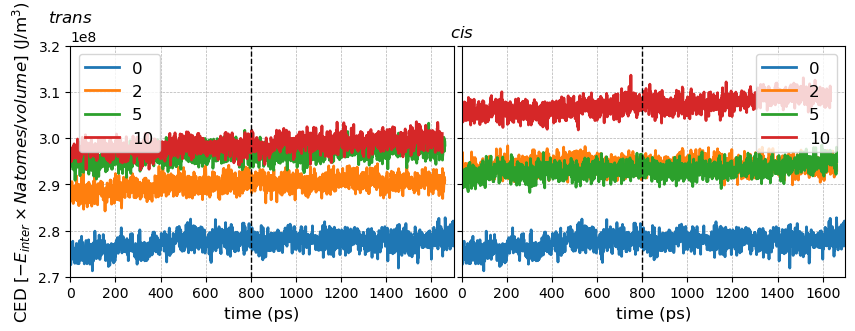

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.02)

for i, iso in enumerate(CED):
    ax[i].set_title(labels[iso], x=0.)
    for N in CED[iso]:
        data = CED[iso][N].copy()
        ax[i].plot(data["time"] - 1000, data["ced"], "-", label=f"{N}")
        
    ax[i].legend()
    ax[i].set_ylabel(r"CED [$-E_{inter} \times Natomes / volume$] (J/m$^3$)")
    
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)
    
    # ax[i].set_ylim(-3.15e8, -2.8e8)
    ax[i].set_ylim(2.70e8, 3.2e8)
    ax[i].set_xlim(0, 1700)
    ax[i].set_xlabel("time (ps)")
    
    ax[i].axvline(x=800, ls="--", lw=1., color="k")
    
    if i != 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")

save_fig("ced_in_time.png", "../figures/")

plt.show()

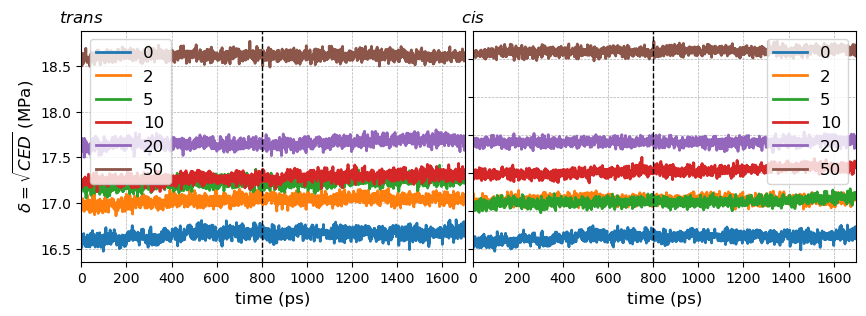

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.02)

for i, iso in enumerate(CED):
    ax[i].set_title(labels[iso], x=0.)
    for N in CED[iso]:
        data = CED[iso][N].copy()
        ax[i].plot(data["time"] - 1000, data["delta"], "-", label=f"{N}")
        
    ax[i].legend()
    ax[i].set_ylabel(r"$\delta=\sqrt{CED}$ (MPa)")
    
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)
    
    # ax[i].set_ylim(-3.15e8, -2.8e8)
    # ax[i].set_ylim(2.70e8, 3.2e8)
    ax[i].set_xlim(0, 1700)
    ax[i].set_xlabel("time (ps)")
    
    ax[i].axvline(x=800, ls="--", lw=1., color="k")
    
    if i != 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")

save_fig("delta_in_time.png", "../figures/")

plt.show()

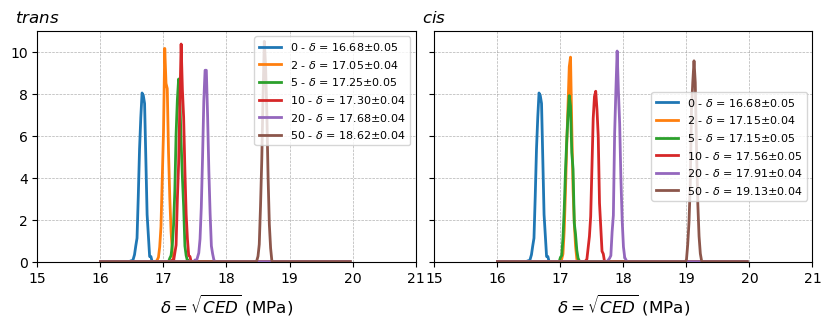

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.05)

bins = np.arange(16, 20, 0.02)

for i, iso in enumerate(CED):
    ax[i].set_title(labels[iso], x=0.)
    for N in CED[iso]:
        data = CED[iso][N].copy()
        data["time"] -= 1000
        
        
        hist, _ = np.histogram(data["delta"][data["time"] > 800.0], bins=bins, density=True)
        mean = data["delta"][data["time"] > 800.0].mean()
        std = data["delta"][data["time"] > 800.0].std()
        
        ax[i].plot(
            bins[:-1],
            hist,
            "-",
            label=r"{} - $\delta$ = {:.2f}$\pm${:.2f}".format(N, mean, std)
        )
        
        
        
    ax[i].legend(fontsize=8)
    ax[i].set_xlabel(r"$\delta=\sqrt{CED}$ (MPa)")
    
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)
    
    ax[i].set_xlim(15, 21)
    # ax[i].set_xlabel("time (ps)")
    ax[i].set_ylim(0, 11)
    
    # ax[i].axvline(x=800, ls="--", lw=1., color="k")
    
    if i != 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")

save_fig("delta_hist.png", "../figures/")
plt.show()

In [50]:
CEDm = {}
for iso in CED:
    CEDm[iso] = {}
    n_pc = []
    means = []
    stds = []
    for N in CED[iso]:
        data = CED[iso][N].copy()
        data["time"] -= 1000

        mean = data["delta"][data["time"] > 800.0].mean()
        std = data["delta"][data["time"] > 800.0].std()
        n_pc.append(N)
        means.append(mean)
        stds.append(std)
        
    data = pd.DataFrame({
        "NPC": np.array(n_pc).astype(np.int64),
        "mean": means,
        "std": std
    })
    
    CEDm[iso] = data

In [46]:
CED["trans"]["0"]["ced"]

0       2.750090e+08
1       2.761105e+08
2       2.725856e+08
3       2.744448e+08
4       2.757981e+08
            ...     
1996    2.782367e+08
1997    2.783283e+08
1998    2.784597e+08
1999    2.771494e+08
2000    2.781084e+08
Name: ced, Length: 2001, dtype: float64

In [47]:
CEDm = {}
for iso in CED:
    CEDm[iso] = {}
    n_pc = []
    means = []
    stds = []
    for N in CED[iso]:
        data = CED[iso][N].copy()
        data["time"] -= 1000

        mean = data["ced"][data["time"] > 800.0].mean()
        std = data["ced"][data["time"] > 800.0].std()
        n_pc.append(N)
        means.append(mean)
        stds.append(std)
        
    data = pd.DataFrame({
        "NPC": np.array(n_pc).astype(np.int64),
        "mean": means,
        "std": std
    })
    
    CEDm[iso] = data

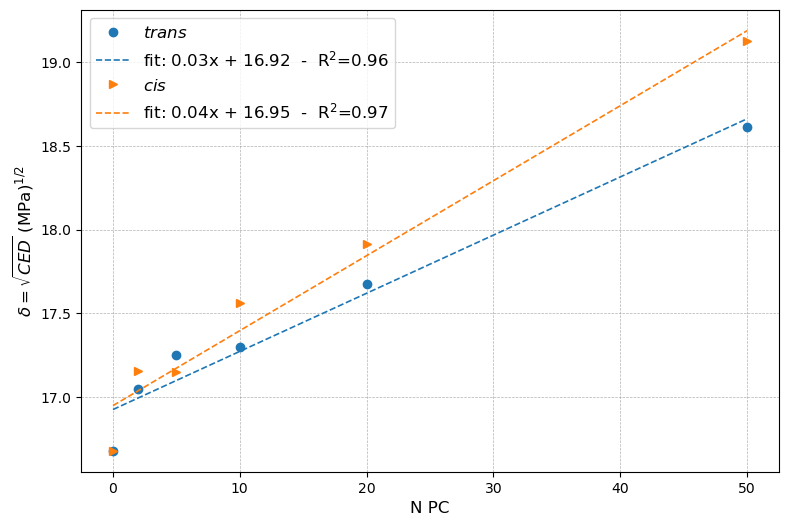

In [52]:
fig, ax = plt.subplots()

iso_colors = {"trans": "tab:blue", "cis":"tab:orange"}

marks = ["o", ">"]

for i, iso in enumerate(CEDm):
    data = CEDm[iso]
    regress = linregress(data["NPC"], data["mean"])
    a = regress[0]
    b = regress[1]
    R2 = regress[2]**2
    ax.plot(data["NPC"], data["mean"], marks[i], label=labels[iso], color=iso_colors[iso])
    
    ax.plot(
        data["NPC"], a*data["NPC"] + b,
        ls="--",
        lw=1.2,
        color=iso_colors[iso],
        label=f"fit: {a:.2f}x + {b:.2f}  -  R$^2$={R2:.2f}"
    )
    
ax.legend()
ax.set_ylabel(r"$\delta=\sqrt{CED}$ (MPa)$^{1/2}$")
# ax.set_ylabel(r"CED [$-E_{inter} \times Natomes / volume$] (J/m$^3$)")
ax.set_xlabel("N PC")
    
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)
# ax.set_ylim(-3.15e8, -2.85e8)

save_fig("delta_vs_npc.png", "../figures/")
plt.show()

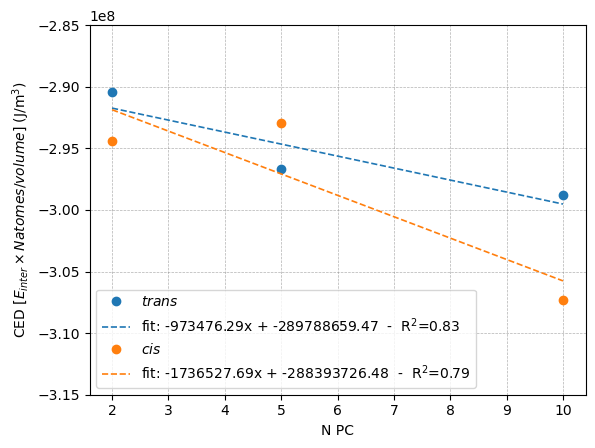

In [91]:
fig, ax = plt.subplots()

iso_colors = {"trans": "tab:blue", "cis":"tab:orange"}

for iso in CEDm:
    data = CEDm[iso]
    regress = linregress(data["NPC"], data["mean"])
    a = regress[0]
    b = regress[1]
    R2 = regress[2]**2
    ax.plot(data["NPC"], data["mean"], "o", label=labels[iso], color=iso_colors[iso])
    
    ax.plot(
        data["NPC"], a*data["NPC"] + b,
        ls="--",
        lw=1.2,
        color=iso_colors[iso],
        label=f"fit: {a:.2f}x + {b:.2f}  -  R$^2$={R2:.2f}"
    )
    
ax.legend()
ax.set_ylabel(r"CED [$E_{inter} \times Natomes / volume$] (J/m$^3$)")
ax.set_xlabel("N PC")
    
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)
ax.set_ylim(-3.15e8, -2.85e8)

save_fig("ced_vs_npc.png", "../figures/")
plt.show()

## Aggregates N20 PC

In [110]:
AGG = []
for iso in ["trans", "cis"]:
    data = pd.read_csv(f"../exp.azob.varN/{iso}/20_agg/5_prod/aggprop.csv")
    data["isomer"] = iso
    AGG.append(data)

AGG = pd.concat(AGG, ignore_index=True)

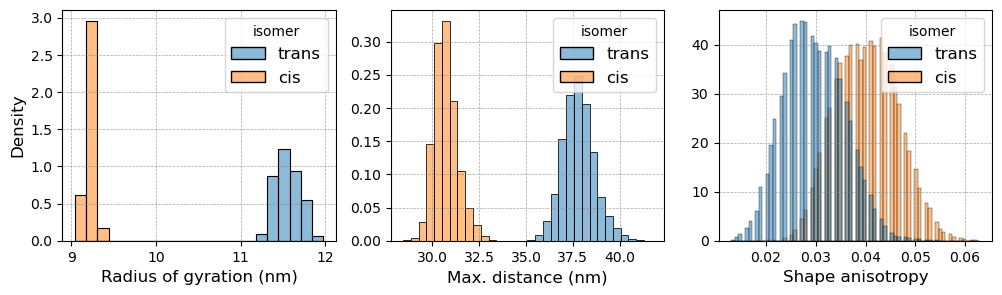

In [121]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # sns.violinplot(data=SIZESall, x="N", y=prop, split=True, inner="quart", ax=ax[i])
    sns.histplot(AGG, x=prop, hue="isomer", ax=ax[i], stat="density") # , binwidth=POLPROP[prop]["binwidth"])
    ax[i].set_xlabel(POLPROP[prop]["label"])
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    
    if i != 0:
        ax[i].set_ylabel("")
    